# Targets: Using Machine Learning Classification Models to Identify Salient Predictors of Cannabis Arrests in New York City, 2006-2018

# Machine Learning Notebook for Classification Models Part II

This notebook continues the work done in Part I, which focused on building classification models that help differentiate cannabis crimes from all other crimes in New York City between 2006-2018. This notebook focuses on building classification models that help differentiate cannabis possession crimes from cannabis sales crimes within the same timeframe. The consequences of getting charged with a sales crime versus a possession crime can have disastrous legal consequences for the perpetrator, and the defining line between these crimes could be enforced in an arbitrary fashion, even though the line typically depends on the amount of cannabis in the perpetrator's possession. To explore this line between possession and sales, the best classification model is uncovered through a process of hyperparameter tuning similar to that done in the first Machine Learning notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
pd.set_option('display.max_columns', 1300)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1296)

A flow chart of the machine learning pipeline for classifying cannabis possession and sales crimes is visualized below. The final outcome of which algorithm performed best, along with the model building strategy classifying the five cannabis crime types from each other, is included in this visualization.

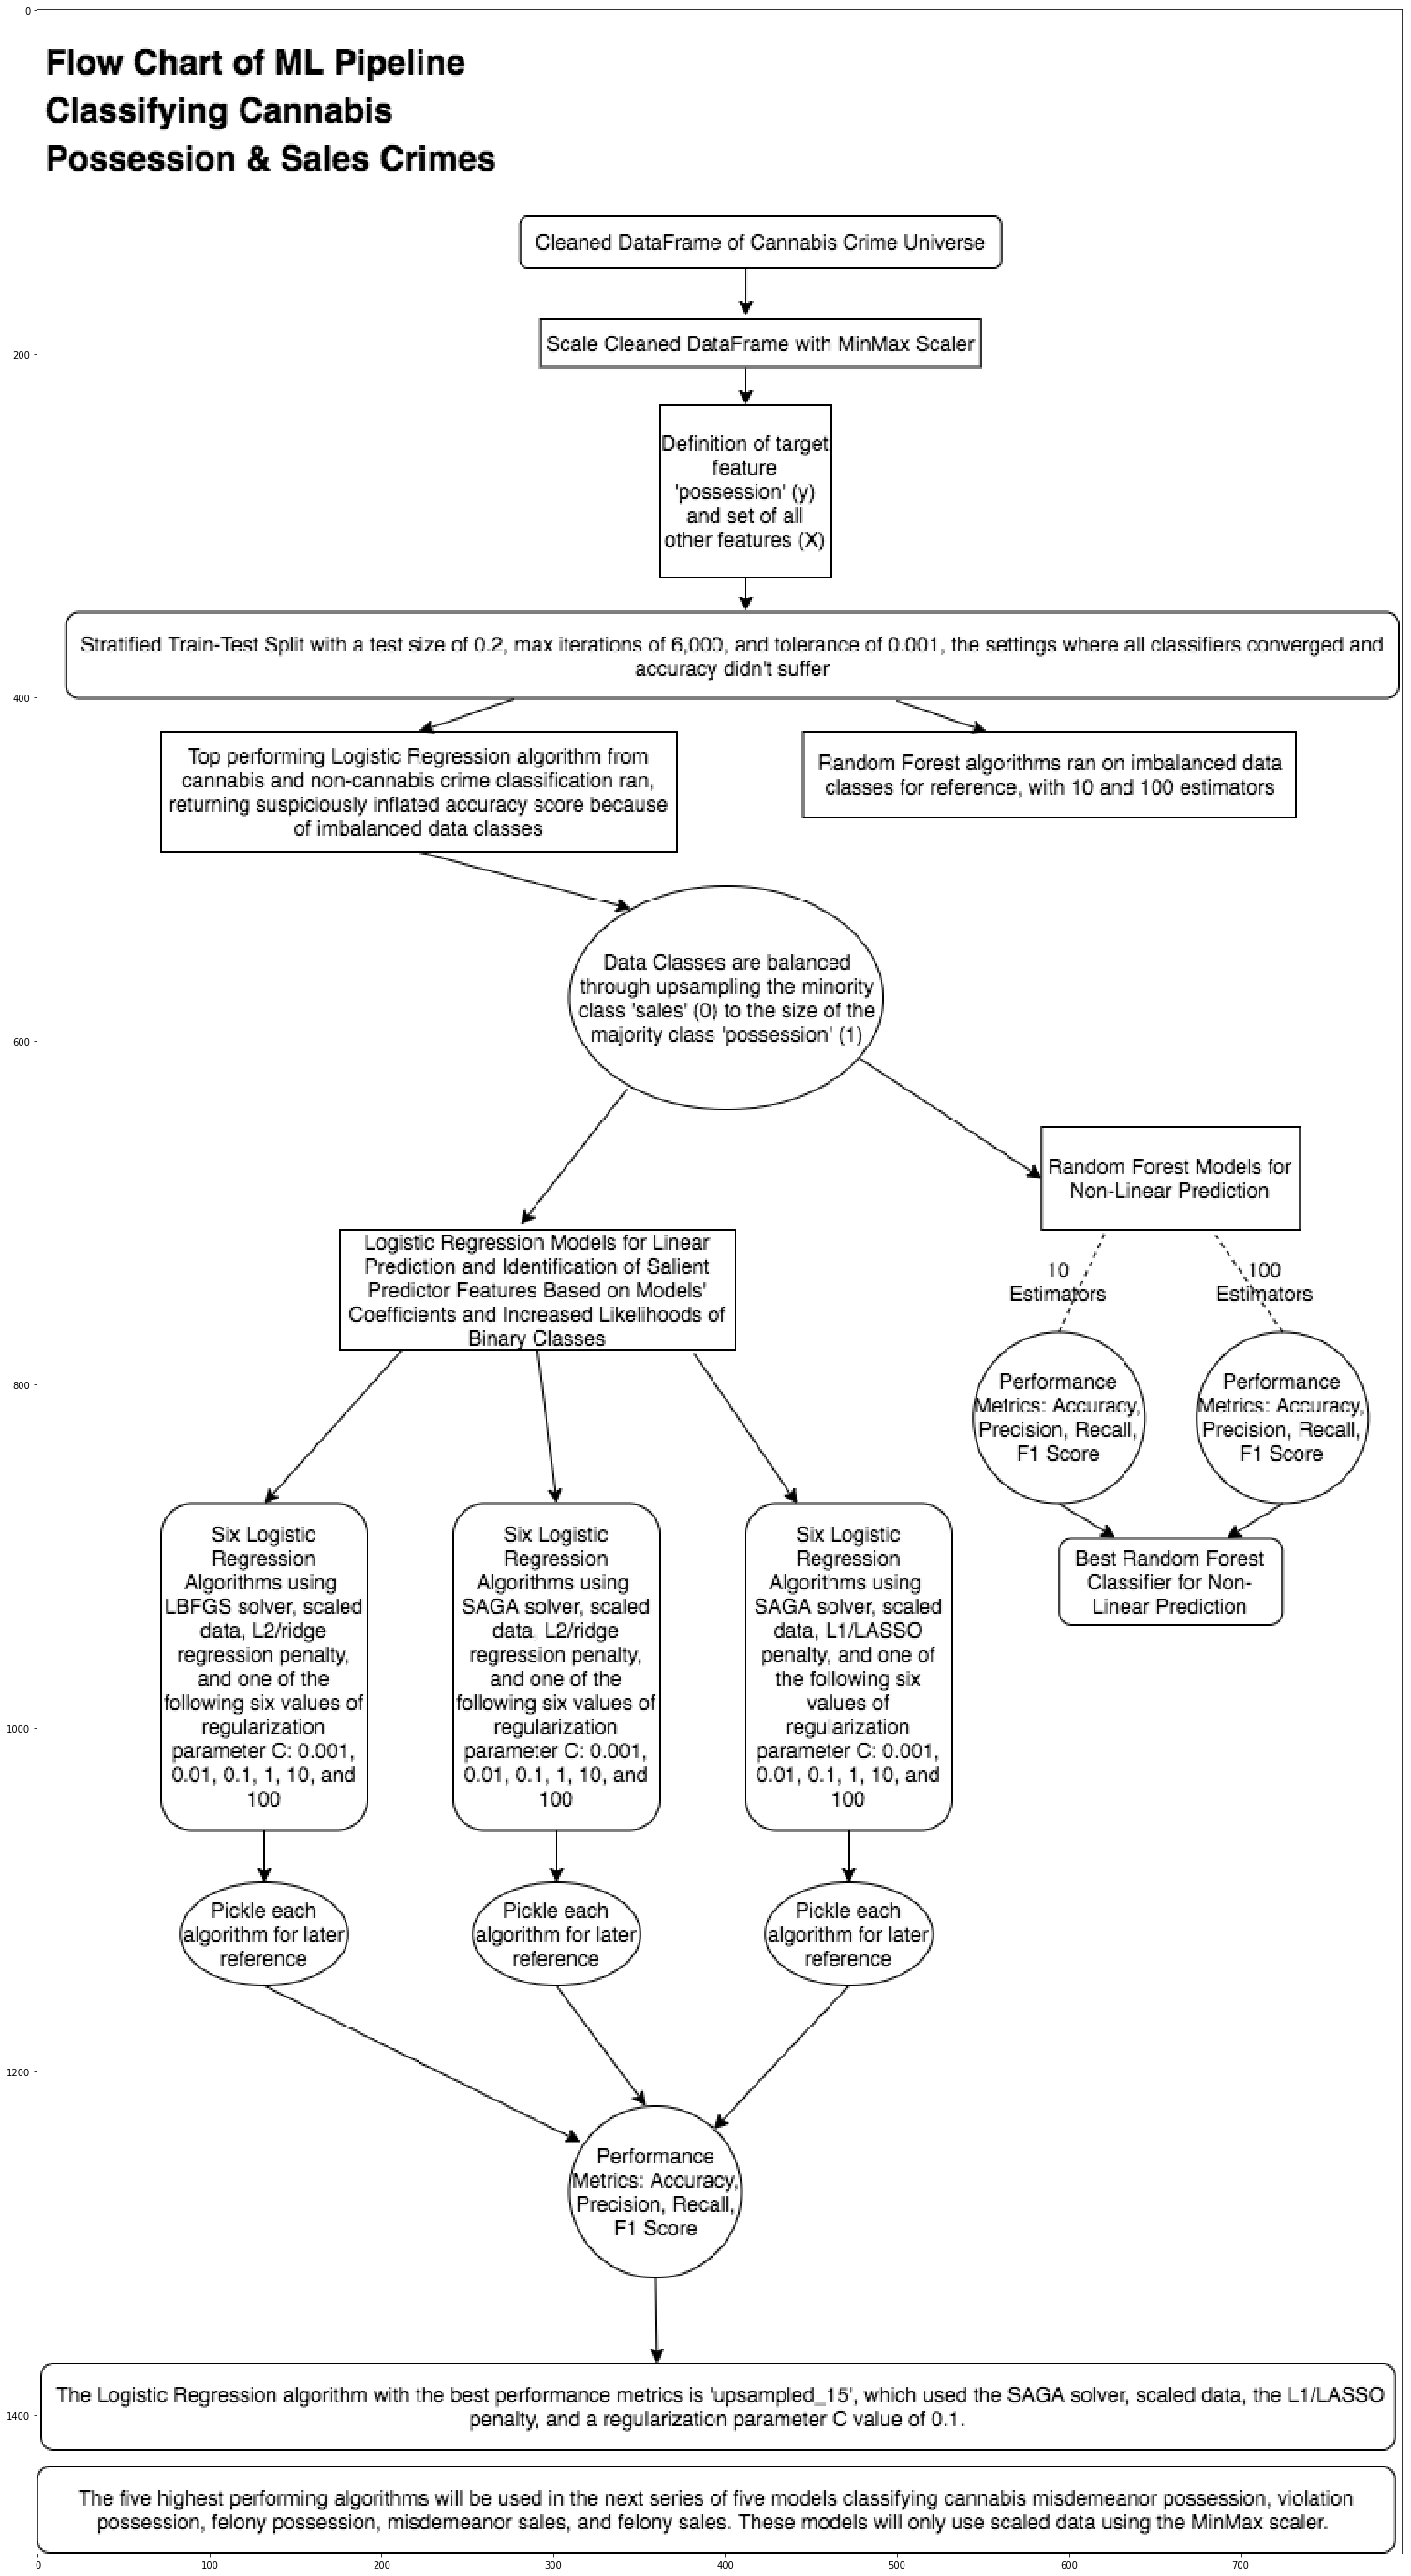

In [3]:
plt.rcParams["figure.figsize"] = (150, 50)
im = plt.imread("Possession vs Sales ML Pipeline.png")
implot = plt.imshow(im)

# Classification of Cannabis Possession Crimes and Cannabis Sales Crimes

The DataFrame of all 220,304 cannabis crimes is loaded into the 'df' DataFrame, and its shape is called for reference.

In [3]:
df = pd.read_csv('nyc_cann_for_ml.csv', index_col=0)

In [4]:
df.shape

(220304, 1302)

The cannabis possession cases have a value of '1' in the 'possession' feature, and cannabis sales cases have a value of '0'. As can be seen, the classes are highly imbalanced with 207,763 possession charges and 12,541 sales charges. This imbalance will need to be addressed in the classification algorithms.

In [4]:
df['possession'].value_counts()

1    207763
0     12541
Name: possession, dtype: int64

The .head() method is called on the 'df' DataFrame for reference.

In [7]:
df.head()

,CMPLNT_NUM,Latitude,Longitude,possession,misd_poss,viol_poss,felony_poss,misd_sales,felony_sales,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKI

## Logistic Regression Classifying Cannabis Possession Crimes and Cannabis Sales Crimes

In part I of the machine learning notebooks, the top two best performing logistic regression algorithms used scaled data, the 'lbfgs' solver, and had C values of 0.1 and 1.0. The top 3rd through 8th best performing logistic regression algorithms used scaled data, the 'saga' solver, and a mixture of penalties and C values. The top 14 best performing logistic algorithms used scaled data, so only scaled data will be used in this notebook. As the DataFrame used in this notebook classifying possession versus sales cannabis crimes is one half of the DataFrame used in part I, the best performing logistic regression algorithms are likely to be similar between the two classification schemes. For this reason, and for the sake of efficiency, the top performing algorithms used in part I will be used here in part II. 

Because this round of classification is focused on cannabis possession and sales crimes, a series of features used elsewhere in the project that also describe the type of crime should be dropped from the DataFrame in order to avoid leakage. These features are dropped in the next cell. 'CMPLNT_NUM' uniquely identifies each crime, so it is also dropped to avoid leakage (as described in the data cleaning notebook for the creation of the cannabis/non-cannabis DataFrame).

In [5]:
df = df.drop(columns = ['CMPLNT_NUM', 'misd_poss', 'viol_poss', 'felony_poss', 'misd_sales', 'felony_sales'])

The .head() method is called again on the edited DataFrame to make sure these unnecessary columns have been dropped.

In [6]:
df.head()

,Latitude,Longitude,possession,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),P

## Logistic Regression Using the Top Performing Algorithms on Scaled Data

For this round of classifications, the best performing Logistic Regression algorithms used in part I are used here on scaled data. In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets, and hyperparameters are tuned to find the best model with the highest accuracy score, precision, recall, and F1 score on the test set. 

In order to tune the hyperparameters, the LogisticRegression classifier is assigned several times with different combinations of hyperparameter values. For each assignment of the classifier, 

a) the classifier is fitted to the training data, 

b) the target feature's values are predicted from the test feature set, 

c) the accuracy score is computed from the test set, 

d) the 'confusion_matrix' and 'classification_report' is called from the test target feature values and predicted test target values to return the precision, recall, and F1 scores, and

e) accuracy, precision, recall, and F1 scores will then be entered into a Hyperparameter Tuning Table in Excel, which will be read into the data space after hyperparameter tuning is resolved. 

After the best combination of hyperparameters are discovered from using the best performing algorithms from part I on scaled data, an ROC curve and the AUC will be calculated and displayed to present a visual image of the evaluation of the best LogisticRegression model.

## Scaling the DataFrame

We now use MinMaxScaler to normalize the data, as it was discovered in the first Machine Learning notebook that classification algorithms using scaled data performed best.

In [7]:
scaler = MinMaxScaler()

In [8]:
scaler.fit(df)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

In [10]:
df_scaled.head()

,Latitude,Longitude,possession,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),P

The target feature in this series of classifications is the binary feature 'possession', with a value of 1 for cannabis possession crimes and 0 for cannabis sales crimes. The target feature is assigned to y.

In [10]:
y = df_scaled['possession']

The feature set is assigned to X, which includes all features in the 'df_scaled' DataFrame which are not the target.

In [11]:
target_names = ['possession']
X = df_scaled[[cn for cn in df_scaled.columns if cn not in target_names]]

## Training and Test Data Split

In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Using the Best Performing Algorithms

In order to tune the hyperparameters, the LogisticRegression classifier is assigned with the L2 penalty, a C value of 0.1, the 'lbfgs' solver, 6,000 max iterations, and a tolerance of 0.001.

In [17]:
lr_1 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001)

In [18]:
lr_1.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=6000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [19]:
y_pred_1 = lr_1.predict(X_test)
y_pred_1[0:35]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [20]:
print(accuracy_score(lr_1.predict(X_test), y_test))

0.943169696557046


The confusion matrix shows that there are 31 true positives, 27 false positives, 2,477 false negatives, and 41,526 true negatives.

In [21]:
print(confusion_matrix(y_test, y_pred_1))

[[   31  2477]
 [   27 41526]]


In [22]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

         0.0       0.53      0.01      0.02      2508
         1.0       0.94      1.00      0.97     41553

   micro avg       0.94      0.94      0.94     44061
   macro avg       0.74      0.51      0.50     44061
weighted avg       0.92      0.94      0.92     44061



The accuracy score returned on this first Logistic Regression algorithm on cannabis possession versus sales crimes is about 10 percentage points higher than those returned for cannabis crimes versus non-cannabis crimes. The confusion matrix and classification report also show extremely unbalanced metrics, apparently from the very imbalanced data classes. For this reason, a protocol involving the oversampling of the minority class is carried out below (as described at https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18). 

This oversampling protocol randomly samples cases from the minority class with replacement until the number of cases in each class are of the same size. This is an acceptable and commonly used strategy for dealing with imbalanced classes in classification models.

But first, a RandomForest classifier is used on the imbalanced training data for exploratory purposes.

## Random Forest Algorithm

It is always a good idea to investigate one other type of classifier when doing machine learning classification. Random Forest is a good choice, as it has been found to be very useful with datasets with large sample and feature sizes, where the feature size is smaller than the sample size. Also, Random Forest is good for imbalanced datasets (https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18). For these reasons, it is carried out below on the original training set.

In [24]:
rfc_1 = RandomForestClassifier().fit(X_train, y_train)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [25]:
rfc_pred_1 = rfc_1.predict(X_test)

In [26]:
accuracy_score(y_test, rfc_pred_1)

0.9347722475658746

The confusion matrix shows that there are 347 true positives, 713 false positives, 2,161 false negatives, and 40,840 true negatives.

In [27]:
confusion_matrix(y_test, rfc_pred_1)

array([[  347,  2161],
       [  713, 40840]])

In [28]:
print(classification_report(y_test, rfc_pred_1))

              precision    recall  f1-score   support

         0.0       0.33      0.14      0.19      2508
         1.0       0.95      0.98      0.97     41553

   micro avg       0.93      0.93      0.93     44061
   macro avg       0.64      0.56      0.58     44061
weighted avg       0.91      0.93      0.92     44061



In [29]:
filename = 'p_v_s_rfc_1.sav'
pickle.dump(rfc_1, open(filename, 'wb'))

At the old default setting of 10 estimators, the Random Forest classifier is not performing much differently than the first LogisticRegression algorithm. The precision for the 'sales' class is 20 percentage points worse for the Random Forest classifier, and its recall and F1 score for the 'sales' class are about 10 percentage points  higher for this first Logistic Regression classifier. For this reason, another RandomForestClassifier is tried, this time with 100 estimators.

In [30]:
rfc_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [31]:
rfc_pred_2 = rfc_2.predict(X_test)

In [32]:
accuracy_score(y_test, rfc_pred_2)

0.9411951612537164

The confusion matrix shows that there are 276 true positives, 359 false positives, 2,232 false negatives, and 41,194 true negatives.

In [33]:
confusion_matrix(y_test, rfc_pred_2)

array([[  276,  2232],
       [  359, 41194]])

In [34]:
print(classification_report(y_test, rfc_pred_2))

              precision    recall  f1-score   support

         0.0       0.43      0.11      0.18      2508
         1.0       0.95      0.99      0.97     41553

   micro avg       0.94      0.94      0.94     44061
   macro avg       0.69      0.55      0.57     44061
weighted avg       0.92      0.94      0.92     44061



In [35]:
filename = 'p_v_s_rfc_2.sav'
pickle.dump(rfc_2, open(filename, 'wb'))

Increasing the number of estimators increased the precision for the 'sales' class by 10 percentage points, but didn't improve the other metrics, and the accuracy is still unnaturally high. For these reasons, the strategy of upsampling the minority class is attempted.

## Upsampling the Minority Class in the Training Set

First, the training data is concatenated back together.

In [13]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [14]:
sales = X[X.possession == 0]
possession = X[X.possession == 1]

Then, the minority class (i.e., sales) is upsampled.

In [15]:
from sklearn.utils import resample
sales_upsampled = resample(sales,
                          replace=True, # sample with replacement
                          n_samples=len(possession), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [16]:
upsampled = pd.concat([possession, sales_upsampled])

The new class counts are checked.

In [17]:
upsampled.possession.value_counts()

0.0    166210
1.0    166210
Name: possession, dtype: int64

The 'y_train' target and 'X_train' feature set is then re-defined.

In [18]:
y_train = upsampled.possession

In [19]:
X_train = upsampled.drop('possession', axis=1)

Logistic regression is tried again with the balanced DataFrame.

In [24]:
upsampled_1 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [25]:
upsampled_pred_1 = upsampled_1.predict(X_test)
upsampled_pred_1[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [40]:
accuracy_score(y_test, upsampled_pred_1)

0.680397630557636

The confusion matrix shows that there are 1,656 true positives, 13,230 false positives, 852 false negatives, and 28,323 true negatives.

In [41]:
print(confusion_matrix(y_test, upsampled_pred_1))

[[ 1656   852]
 [13230 28323]]


In [42]:
print(classification_report(y_test, upsampled_pred_1))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [74]:
filename = 'p_v_s_upsampled_1.sav'
pickle.dump(upsampled_1, open(filename, 'wb'))

Because the classification of cannabis possession and cannabis sales is performing so differently from the classification algorithms used on cannabis crimes and non-cannabis crimes, it makes sense to try all of the algorithms used on scaled data in Part I, not just the best performing ones. The algorithms run on scaled data overwhelmingly performed better than those run on unscaled data, so only scaled data will be used for classifying cannabis possession from cannabis sales. These algorithms are run below, on the resampled training set.

In [43]:
upsampled_2 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [44]:
upsampled_pred_2 = upsampled_2.predict(X_test)
upsampled_pred_2[0:35]

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1.])

In [45]:
accuracy_score(y_test, upsampled_pred_2)

0.6605841901000885

The confusion matrix shows that there are 1,669 true positives, 14,116 false positives, 839 false negatives, and 27,437 true negatives.

In [46]:
print(confusion_matrix(y_test, upsampled_pred_2))

[[ 1669   839]
 [14116 27437]]


In [47]:
print(classification_report(y_test, upsampled_pred_2))

              precision    recall  f1-score   support

         0.0       0.11      0.67      0.18      2508
         1.0       0.97      0.66      0.79     41553

   micro avg       0.66      0.66      0.66     44061
   macro avg       0.54      0.66      0.48     44061
weighted avg       0.92      0.66      0.75     44061



In [75]:
filename = 'p_v_s_upsampled_2.sav'
pickle.dump(upsampled_2, open(filename, 'wb'))

In [48]:
upsampled_3 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [49]:
upsampled_pred_3 = upsampled_3.predict(X_test)
upsampled_pred_3[0:35]

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [50]:
accuracy_score(y_test, upsampled_pred_3)

0.6787862281836545

The confusion matrix shows that there are 1,672 true positives, 13,317 false positives, 836 false negatives, and 28,236 true negatives.

In [51]:
print(confusion_matrix(y_test, upsampled_pred_3))

[[ 1672   836]
 [13317 28236]]


In [52]:
print(classification_report(y_test, upsampled_pred_3))

              precision    recall  f1-score   support

         0.0       0.11      0.67      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.76     44061



In [76]:
filename = 'p_v_s_upsampled_3.sav'
pickle.dump(upsampled_3, open(filename, 'wb'))

In [53]:
upsampled_4 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [54]:
upsampled_pred_4 = upsampled_4.predict(X_test)
upsampled_pred_4[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [55]:
accuracy_score(y_test, upsampled_pred_4)

0.6801025850525408

The confusion matrix shows that there are 1,662 true positives, 13,249 false positives, 846 false negatives, and 28,304 true negatives.

In [56]:
print(confusion_matrix(y_test, upsampled_pred_4))

[[ 1662   846]
 [13249 28304]]


In [57]:
print(classification_report(y_test, upsampled_pred_4))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [77]:
filename = 'p_v_s_upsampled_4.sav'
pickle.dump(upsampled_4, open(filename, 'wb'))

In [58]:
upsampled_5 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [59]:
upsampled_pred_5 = upsampled_5.predict(X_test)
upsampled_pred_5[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [60]:
accuracy_score(y_test, upsampled_pred_5)

0.6798983227797826

The confusion matrix shows that there are 1,662 true positives, 13,258 false positives, 846 false negatives, and 28,295 true negatives.

In [61]:
print(confusion_matrix(y_test, upsampled_pred_5))

[[ 1662   846]
 [13258 28295]]


In [62]:
print(classification_report(y_test, upsampled_pred_5))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [65]:
filename = 'p_v_s_upsampled_5.sav'
pickle.dump(upsampled_5, open(filename, 'wb'))

In [67]:
upsampled_6 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='lbfgs', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [68]:
upsampled_pred_6 = upsampled_6.predict(X_test)
upsampled_pred_6[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [69]:
accuracy_score(y_test, upsampled_pred_6)

0.6795124940423504

The confusion matrix shows that there are 1,664 true positives, 13,277 false positives, 844 false negatives, and 28,276 true negatives.

In [70]:
confusion_matrix(y_test, upsampled_pred_6)

array([[ 1664,   844],
       [13277, 28276]])

In [72]:
print(classification_report(y_test, upsampled_pred_6))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [73]:
filename = 'p_v_s_upsampled_6.sav'
pickle.dump(upsampled_6, open(filename, 'wb'))

In [78]:
upsampled_7 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [79]:
upsampled_pred_7 = upsampled_7.predict(X_test)
upsampled_pred_7[0:35]

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1.])

In [80]:
accuracy_score(y_test, upsampled_pred_7)

0.6605614942920043

The confusion matrix shows that there are 1,669 true positives, 14,117 false positives, 839 false negatives, and 27,436 true negatives.

In [81]:
confusion_matrix(y_test, upsampled_pred_7)

array([[ 1669,   839],
       [14117, 27436]])

In [83]:
print(classification_report(y_test, upsampled_pred_7))

              precision    recall  f1-score   support

         0.0       0.11      0.67      0.18      2508
         1.0       0.97      0.66      0.79     41553

   micro avg       0.66      0.66      0.66     44061
   macro avg       0.54      0.66      0.48     44061
weighted avg       0.92      0.66      0.75     44061



In [84]:
filename = 'p_v_s_upsampled_7.sav'
pickle.dump(upsampled_7, open(filename, 'wb'))

In [85]:
upsampled_8 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [86]:
upsampled_pred_8 = upsampled_8.predict(X_test)
upsampled_pred_8[0:35]

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [87]:
accuracy_score(y_test, upsampled_pred_8)

0.6786273575270647

The confusion matrix shows that there are 1,673 true positives, 13,325 false positives, 835 false negatives, and 28,228 true negatives.

In [88]:
confusion_matrix(y_test, upsampled_pred_8)

array([[ 1673,   835],
       [13325, 28228]])

In [90]:
print(classification_report(y_test, upsampled_pred_8))

              precision    recall  f1-score   support

         0.0       0.11      0.67      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.76     44061



In [91]:
filename = 'p_v_s_upsampled_8.sav'
pickle.dump(upsampled_8, open(filename, 'wb'))

In [92]:
upsampled_9 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [93]:
upsampled_pred_9 = upsampled_9.predict(X_test)
upsampled_pred_9[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [94]:
accuracy_score(y_test, upsampled_pred_9)

0.6804203263657203

The confusion matrix shows that there are 1,656 true positives, 13,329 false positives, 852 false negatives, and 28,324 true negatives.

In [95]:
confusion_matrix(y_test, upsampled_pred_9)

array([[ 1656,   852],
       [13229, 28324]])

In [98]:
print(classification_report(y_test, upsampled_pred_9))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [97]:
filename = 'p_v_s_upsampled_9.sav'
pickle.dump(upsampled_9, open(filename, 'wb'))

In [99]:
upsampled_10 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [100]:
upsampled_pred_10 = upsampled_10.predict(X_test)
upsampled_pred_10[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [101]:
accuracy_score(y_test, upsampled_pred_10)

0.6800571934363723

The confusion matrix shows that there are 1,662 true positives, 13,251 false positives, 846 false negatives, and 28,302 true negatives.

In [104]:
confusion_matrix(y_test, upsampled_pred_10)

array([[ 1662,   846],
       [13251, 28302]])

In [105]:
print(classification_report(y_test, upsampled_pred_10))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [106]:
filename = 'p_v_s_upsampled_10.sav'
pickle.dump(upsampled_10, open(filename, 'wb'))

In [107]:
upsampled_11 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [108]:
upsampled_pred_11 = upsampled_11.predict(X_test)
upsampled_pred_11[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [109]:
accuracy_score(y_test, upsampled_pred_11)

0.6796713646989401

The confusion matrix shows that there are 1,659 true positives, 13,265 false positives, 849 false negatives, and 28,288 true negatives.

In [110]:
confusion_matrix(y_test, upsampled_pred_11)

array([[ 1659,   849],
       [13265, 28288]])

In [111]:
print(classification_report(y_test, upsampled_pred_11))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [112]:
filename = 'p_v_s_upsampled_11.sav'
pickle.dump(upsampled_11, open(filename, 'wb'))

In [113]:
upsampled_12 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [114]:
upsampled_pred_12 = upsampled_12.predict(X_test)
upsampled_pred_12[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [115]:
accuracy_score(y_test, upsampled_pred_12)

0.6799664102040354

The confusion matrix shows that there are 1,664 true positives, 13,257 false positives, 844 false negatives, and 28,296 true negatives.

In [116]:
confusion_matrix(y_test, upsampled_pred_12)

array([[ 1664,   844],
       [13257, 28296]])

In [117]:
print(classification_report(y_test, upsampled_pred_12))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [118]:
filename = 'p_v_s_upsampled_12.sav'
pickle.dump(upsampled_12, open(filename, 'wb'))

In [119]:
upsampled_13 = linear_model.LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [121]:
upsampled_pred_13 = upsampled_13.predict(X_test)
upsampled_pred_13[0:35]

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1.])

In [122]:
accuracy_score(y_test, upsampled_pred_13)

0.6408842286829622

The confusion matrix shows that there are 1,646 true positives, 14,961 false positives, 862 false negatives, and 26,592 true negatives.

In [123]:
confusion_matrix(y_test, upsampled_pred_13)

array([[ 1646,   862],
       [14961, 26592]])

In [124]:
print(classification_report(y_test, upsampled_pred_13))

              precision    recall  f1-score   support

         0.0       0.10      0.66      0.17      2508
         1.0       0.97      0.64      0.77     41553

   micro avg       0.64      0.64      0.64     44061
   macro avg       0.53      0.65      0.47     44061
weighted avg       0.92      0.64      0.74     44061



In [125]:
filename = 'p_v_s_upsampled_13.sav'
pickle.dump(upsampled_13, open(filename, 'wb'))

In [126]:
upsampled_14 = linear_model.LogisticRegression(penalty='l1', C=0.01, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [127]:
upsampled_pred_14 = upsampled_14.predict(X_test)
upsampled_pred_14[0:35]

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [128]:
accuracy_score(y_test, upsampled_pred_14)

0.6752002905063434

The confusion matrix shows that there are 1,663 true positives, 13,466 false positives, 845 false negatives, and 28,087 true negatives.

In [129]:
confusion_matrix(y_test, upsampled_pred_14)

array([[ 1663,   845],
       [13466, 28087]])

In [130]:
print(classification_report(y_test, upsampled_pred_14))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.49     44061
weighted avg       0.92      0.68      0.76     44061



In [131]:
filename = 'p_v_s_upsampled_14.sav'
pickle.dump(upsampled_14, open(filename, 'wb'))

In [20]:
upsampled_15 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [21]:
upsampled_pred_15 = upsampled_15.predict(X_test)
upsampled_pred_15[0:35]

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [22]:
accuracy_score(y_test, upsampled_pred_15)

0.6815778125780169

The confusion matrix shows that there are 1,656 true positives, 13,178 false positives, 852 false negatives, and 28,375 true negatives.

In [32]:
confusion_matrix(y_test, upsampled_pred_15)

array([[ 1656,   852],
       [13178, 28375]])

In [33]:
print(classification_report(y_test, upsampled_pred_15))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [88]:
filename = 'p_v_s_upsampled_15.sav'
pickle.dump(upsampled_15, open(filename, 'wb'))

In [138]:
upsampled_16 = linear_model.LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [139]:
upsampled_pred_16 = upsampled_16.predict(X_test)
upsampled_pred_16[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [140]:
accuracy_score(y_test, upsampled_pred_16)

0.6799210185878668

The confusion matrix shows that there are 1,661 true positives, 13,256 false positives, 847 false negatives, and 28,297 true negatives.

In [141]:
confusion_matrix(y_test, upsampled_pred_16)

array([[ 1661,   847],
       [13256, 28297]])

In [142]:
print(classification_report(y_test, upsampled_pred_16))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [143]:
filename = 'p_v_s_upsampled_16.sav'
pickle.dump(upsampled_16, open(filename, 'wb'))

In [43]:
upsampled_17 = linear_model.LogisticRegression(penalty='l1', C=10.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [44]:
upsampled_pred_17 = upsampled_17.predict(X_test)
upsampled_pred_17[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [45]:
accuracy_score(y_test, upsampled_pred_17)

0.6794897982342661

The confusion matrix shows that there are 1,661 true positives, 13,275 false positives, 847 false negatives, and 28,278 true negatives.

In [46]:
confusion_matrix(y_test, upsampled_pred_17)

array([[ 1661,   847],
       [13275, 28278]])

In [47]:
print(classification_report(y_test, upsampled_pred_17))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [48]:
filename = 'p_v_s_upsampled_17.sav'
pickle.dump(upsampled_17, open(filename, 'wb'))

In [49]:
upsampled_18 = linear_model.LogisticRegression(penalty='l1', C=100.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [50]:
upsampled_pred_18 = upsampled_18.predict(X_test)
upsampled_pred_18[0:35]

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1.])

In [51]:
accuracy_score(y_test, upsampled_pred_18)

0.6793082317695922

The confusion matrix shows that there are 1,661 true positives, 13,283 false positives, 847 false negatives, and 28,270 true negatives.

In [52]:
confusion_matrix(y_test, upsampled_pred_18)

array([[ 1661,   847],
       [13283, 28270]])

In [53]:
print(classification_report(y_test, upsampled_pred_18))

              precision    recall  f1-score   support

         0.0       0.11      0.66      0.19      2508
         1.0       0.97      0.68      0.80     41553

   micro avg       0.68      0.68      0.68     44061
   macro avg       0.54      0.67      0.50     44061
weighted avg       0.92      0.68      0.77     44061



In [54]:
filename = 'p_v_s_upsampled_18.sav'
pickle.dump(upsampled_18, open(filename, 'wb'))

## Best LogisticRegression Algorithm

The best performing LogisticRegression algorithm is 'upsampled_15', which uses the 'Saga' solver, L1 penalty, and a C value of 0.1. This will be used to call the coefficients for the feature set. 

## Random Forest Algorithm

It is always a good idea to investigate at least one other type of classifier when doing machine learning classification. Random Forest is a good choice, as it has been found to be very useful with datasets with large sample and feature sizes, where the feature size is smaller than the sample size. Also, Random Forest is good for imbalanced datasets (https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18). A Random Forest classifier was used on the original training data above, but it is also carried out below on the upsampled training data out of experimental interest. First, 10 estimators, and then 100 estimators are tried.

In [55]:
rfc_3 = RandomForestClassifier().fit(X_train, y_train)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [57]:
rfc_pred_3 = rfc_3.predict(X_test)
rfc_pred_3[0:35]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1.])

In [58]:
accuracy_score(y_test, rfc_pred_3)

0.9205873675132203

The confusion matrix shows that there are 525 true positives, 1,516 false positives, 1,983 false negatives, and 40,037 true negatives.

In [59]:
confusion_matrix(y_test, rfc_pred_3)

array([[  525,  1983],
       [ 1516, 40037]])

In [60]:
print(classification_report(y_test, rfc_pred_3))

              precision    recall  f1-score   support

         0.0       0.26      0.21      0.23      2508
         1.0       0.95      0.96      0.96     41553

   micro avg       0.92      0.92      0.92     44061
   macro avg       0.61      0.59      0.59     44061
weighted avg       0.91      0.92      0.92     44061



In [61]:
filename = 'p_v_s_rfc_3.sav'
pickle.dump(rfc_3, open(filename, 'wb'))

In [62]:
rfc_4 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [65]:
rfc_pred_4 = rfc_4.predict(X_test)
rfc_pred_4[0:35]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1.])

In [66]:
accuracy_score(y_test, rfc_pred_4)

0.9311182224643109

The confusion matrix shows that there are 464 true positives, 991 false positives, 2,044 false negatives, and 40,562 true negatives.

In [67]:
confusion_matrix(y_test, rfc_pred_4)

array([[  464,  2044],
       [  991, 40562]])

In [68]:
print(classification_report(y_test, rfc_pred_4))

              precision    recall  f1-score   support

         0.0       0.32      0.19      0.23      2508
         1.0       0.95      0.98      0.96     41553

   micro avg       0.93      0.93      0.93     44061
   macro avg       0.64      0.58      0.60     44061
weighted avg       0.92      0.93      0.92     44061



In [69]:
filename = 'p_v_s_rfc_4.sav'
pickle.dump(rfc_4, open(filename, 'wb'))

## Best Performing Classification Algorithm for Cannabis Possession and Cannabis Sales Crimes

The best performing classification algorithm is the Random Forest algorithm with 100 estimators. The only metric where it is far lower than the 'upsampled_15' LogisticRegression algorithm is recall (or true positive rate) for the cannabis sales class (0.19 vs. 0.66). However, the weighted average of recall is 0.93 for the Random Forest algorithm with 100 estimators versus 0.68 for the 'upsampled_15' LogisticRegression classifier. The F1 score is also consistently higher in the Random Forest algorithm. For these reasons, the Random Forest algorithm with 100 estimators performs the best, but the 'upsampled_15' LogisticRegression algorithm will still be used to call the coefficients for the feature set as RandomForest is incapable of doing so, and these coefficients will help highlight the most salient features that differentiate cannabis possession arrests from cannabis sales arrests. The hyperparameter tuning table for cannabis possession and cannabis sales crimes is shown below, for reference.

In [43]:
sales_v_poss_metrics = pd.read_excel('HP tuning table.xlsx', sheet_name='Possession_v_Sales')
sales_v_poss_metrics

,UPSAMPLED,LR_#,Accuracy_Score,Precision_Sales,Precision_Possession,Precision_Wtd_Average,Recall_Sales,Recall_Possession,Recall_Wtd_Average,F1_Score_Sales,F1_Score_Possession,F1_Score_Wtd_Average,Support_Sales,Support_Possession,Support_Total
0,"RF, scaled, 100 n_estimators",rfc_4,0.931118,0.32,0.95,0.92,0.19,0.98,0.93,0.23,0.96,0.92,2508.0,41553.0,44061.0
1,"RF, scaled, 10 n_estimators",rfc_3,0.920587,0.26,0.95,0.91,0.21,0.96,0.92,0.23,0.96,0.92,2508.0,41553.0,44061.0
2,"LR, scaled, saga solver, L1 penalty, C=0.1",upsampled_15,0.681578,0.11,0.97,0.92,0.66,0.68,0.68,0.19,0.80,0.77,2508.0,41553.0,44061.0
3,"LR, scaled, saga solver, L2 penalty, C=0.1",upsampled_9,0.680420,0.11,0.97,0.92,0.66,0.68,0.68,0.19,0.80,0.77,2508.0,41553.0,44061.0
4,"LR, scaled, lbfgs solver, L2 penalty, C=0.1",upsampled_1,0.680398,0.11,0.97,0.92,0.66,0.68,0.68,0.19,0.80,0.77,2508.0,41553.0,44061.0
5,"LR, scaled, lbfgs solver, L2 penalty, C=1.0",upsampled_4,0.680103,0.11,0.97,0.92,0.66,0.68,0.68,0.19,0.80,0.77,2508.0,41553.0,44061.0
6,"LR, scaled, saga solver, L2 penalty, C=1.0",upsampled_10,0.680057,0.11,0.97,0.92,0.66,0.68,0.68,0.19,0.80,0.77,2508.0,41553.0,44061.0
7,"LR, scaled, saga solver, L2 penalty, C=100.0",upsampled_12,0.679966,0.11,0.97,0.92,0.66,0.68,0.68,0.19,0.80,0.77,2508.0,41553.0,44061.0
8,"LR, scaled, saga solver, L1 penalty, C=1.0",upsampled_16,0.679921,0.11,0.97,0.92,0.66,0.68,0.68,0.19,0.80,0.77,2508.0,41553.0,44061.0
9,"LR, scaled, lbfgs solver, L2 penalty, C=10.0",upsampled_5,0.679898,0.11,0.97,0.92,0.66,0.68,0.68,0.19,0.80,0.77,2508.0,41553.0,44061.0


## ROC curve and AUC

The Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are called on both the Random Forest algorithm with 100 estimators, and on the best LogisticRegression algorithm ('upsampled_15'). This is done to further evaluate the model as described in the part I machine learning notebook.

First, the ROC curve for the RandomForest model with 100 estimators is calculated and plotted, and its AUC score is returned.

In [74]:
y_pred_prob_rfc_4 = rfc_4.predict_proba(X_test)[:,1]
y_pred_prob_rfc_4

array([0.47, 0.95, 1.  , ..., 1.  , 1.  , 0.66])

In [76]:
fpr_rfc_4, tpr_rfc_4, thresholds_rfc_4 = roc_curve(y_test, y_pred_prob_rfc_4)

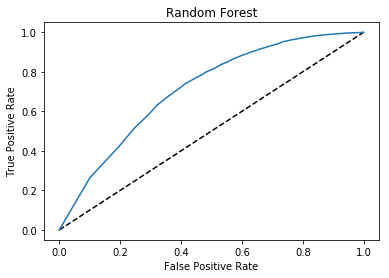

In [78]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rfc_4, tpr_rfc_4, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest')
plt.show();

In [79]:
auc_score_rfc_4 = roc_auc_score(y_test, y_pred_prob_rfc_4)
auc_score_rfc_4

0.7118105368478703

Next, the ROC curve for the best performing LogisticRegression model ('lr_15') is calculated and plotted, and its AUC score is returned.

In [21]:
y_pred_prob_lr_15 = upsampled_15.predict_proba(X_test)[:,1]
y_pred_prob_lr_15

array([0.43552306, 0.71265599, 0.63292034, ..., 0.90882442, 0.75457175,
       0.9236405 ])

In [22]:
fpr_lr_15, tpr_lr_15, thresholds_lr_15 = roc_curve(y_test, y_pred_prob_lr_15)

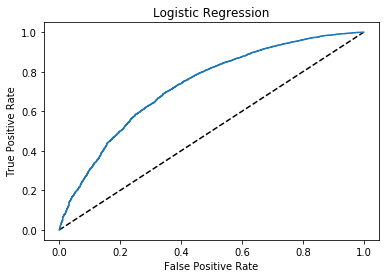

In [23]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr_15, tpr_lr_15, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.show();

In [24]:
auc_score_lr_15 = roc_auc_score(y_test, y_pred_prob_lr_15)
auc_score_lr_15

0.7299796956144209

The 15th LogisticRegression algorithm has a slightly higher AUC score (0.73) than the Random Forest classifier with 100 estimators (0.71).

## Precision Recall Curve

Because of the imbalanced class count, the 15th LogisticRegression algorithm is evaluated below with a Precision-Recall Curve, as recommended by this article by Jason Brownlee, PhD: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/. As Dr. Brownlee says, the future performance of a model with imbalanced class counts is better evaluated with a Precision-Recall Curve than an ROC curve. Specific modules are first imported for use in calculating the Precision-Recall Curve.

In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

The precision recall curve is defined below, as is the F1 score and AUC for the precision-recall curve.

In [26]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob_lr_15)

In [27]:
lr_f1, lr_auc = f1_score(y_test, upsampled_pred_15), auc(lr_recall, lr_precision)

The F1 score is then called, as is the area under the Precision Recall Curve.

In [28]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.802 auc=0.974


The precision-recall curve is then plotted for the best Logistic Regression algorithm ('upsampled_15'). The precision-recall curve's AUC score (0.974) is much higher than the ROC curve's AUC (0.729), showing that the model is skilled at differentiating true positives from false positives and false negatives.

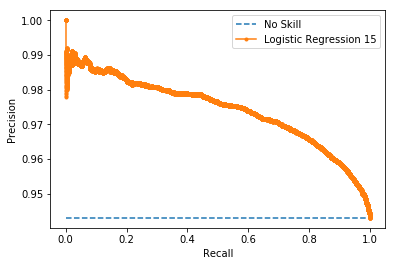

In [29]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression 15')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Evaluation of the Classification Models

The best LogisticRegression model ('upsampled_15') has an accuracy of 0.681577812578016, showing that it makes correct predictions on roughly 68.2% of the data points in the DataFrame. This is quite a bit lower than the .843 accuracy of the model classifying cannabis crimes from non-cannabis crimes, suggesting that the model's coefficients may not be as illustrative of the true relationship between the feature set and the target classes of cannabis possession and sales.

The model's precision is 0.97 for the cannabis possession class (the 1 class), 0.11 for the cannabis sales class (the 0 class), and 0.92 on weighted average, showing that 97% of predicted cannabis possession crimes are actual cannabis possession crimes, 11% of predicted cannabis sales crimes are actual cannabis sales crimes, and 92% of crimes on weighted average are predicted correctly. 

The model's recall is 0.68 for the cannabis possession class (the 1 class), 0.66 for the cannabis sales class (0), and 0.68 on weighted average, showing that 68% of actual cannabis possession crimes are predicted as cannabis possession crimes, 66% of actual cannabis sales crimes are predicted as cannabis sales crimes, and that 68% of crimes on weighted average are predicted correctly.

The model's F1 score, or harmonic mean of precision and recall, is 0.80 for the cannabis possession class, 0.19 for the cannabis sales class, and 0.77 on weighted average. This metric is more informative than precision or recall alone, and shows that 80% of cannabis possession crimes and 19% of cannabis sales crimes are being predicted correctly, for a weighted average of 77%.

The ROC curves plotted above show that the best LogisticRegression model ('upsampled_15') has an ROC AUC score of 72.9%, showing that it is a moderately skillful model in predicting cannabis possession crimes at a rate higher than random. The Precision Recall Curve has an AUC score of 97.4%. The higher Precision Recall AUC score shows that the model is skilled at differentiating true positives from false positives and false negatives, especially for the cannabis possession class. However, as is shown above, it is not as skillful at predicting cannabis sales crimes.

The RandomForest model with 100 estimators has an accuracy of 0.93111822246431. It has a 0.95 precision score for the cannabis possession class, a 0.32 precision score for the cannabis sales class, and a weighted average precision score of 0.92. It has a recall score of 0.98 for the cannabis possession class, a 0.19 recall score for the cannabis sales class, and a weighted average recall score of 0.93. It has a 0.96 F1 score for the cannabis possession class, a 0.23 F1 score for the cannabis sales class, and a weighted average F1 score of 0.92. The ROC curve plotted above shows that it has an AUC score of 71.2%. Therefore this is not a very skillful model, and  because of its non-linear nature cannot uncover the features in the NYPD's dataset that have the strongest relationship with cannabis possession and sales crimes. 

## Coefficients

In order to look at the most salient predictors of cannabis possession and sales crimes in New York City between 2006-2018, the feature set's coefficients for the best performing Logistic Regression algorithm ('upsampled_15') are identified to find the most predictive features differentiating cannabis possession from cannabis sales crimes.

First, the coefficients are called for all the features in the feature set, assigned to 'best_cf_coeffs' (short for 'best classifier's coefficients').

In [23]:
best_cf_coeffs = pd.Series(upsampled_15.coef_[0], index=X_train.columns) 
best_cf_coeffs

Latitude                                                                        0.000000e+00
Longitude                                                                       0.000000e+00
duration_days                                                                   0.000000e+00
start_year                                                                      6.482240e-01
start_month                                                                    -8.352214e-02
start_day                                                                      -1.878629e-02
start_hour                                                                      1.197320e-01
start_minute                                                                    1.533940e-01
start_seconds                                                                   0.000000e+00
rpt_cmplnt_dt_match                                                             4.287242e-01
day_tw                                                                

The features' coefficients are then sorted to show the features most predictive of cannabis possession and sales crimes. The features with positive coefficients are more predictive of possession crimes, while the features with negative coefficients are more predictive of sales crimes.

In [24]:
sorted_best_cf_coeffs = best_cf_coeffs.sort_values()
sorted_best_cf_coeffs

PARKS_NM_WASHINGTON SQUARE PARK                                                -3.409492e+00
STATION_NAME_JACKSON AVENUE                                                    -3.263398e+00
STATION_NAME_LEXINGTON AVE.                                                    -2.623754e+00
STATION_NAME_PENNSYLVANIA AVENUE                                               -2.067500e+00
SUSP_AGE_GROUP_cleaned_unknown                                                 -1.965508e+00
PREM_TYP_DESC_LIQUOR STORE                                                     -1.954091e+00
wtc_l2                                                                         -1.810898e+00
PARKS_NM_PARKSIDE PLAYGROUND BROOKLYN                                          -1.805982e+00
PREM_TYP_DESC_GROCERY/BODEGA                                                   -1.804376e+00
HADEVELOPT_POMONOK                                                             -1.780963e+00
PARKS_NM_ST. JAMES PARK                                               

## Sales Coefficients

To look at which features have the strongest relationship to cannabis sales crime, the features that have at least a 0.699809 coefficient are called and speculated on below by assigning the object 'sales_coeffs'. When exponentiated by assigning the object 'sales_coeffs_lls', these features are shown to provide at least a 2% increase in the odds of a cannabis crime being a sales crime.

In [25]:
sales_coeffs = sorted_best_cf_coeffs[0:57].sort_values()
sales_coeffs

PARKS_NM_WASHINGTON SQUARE PARK                      -3.409492
STATION_NAME_JACKSON AVENUE                          -3.263398
STATION_NAME_LEXINGTON AVE.                          -2.623754
STATION_NAME_PENNSYLVANIA AVENUE                     -2.067500
SUSP_AGE_GROUP_cleaned_unknown                       -1.965508
PREM_TYP_DESC_LIQUOR STORE                           -1.954091
wtc_l2                                               -1.810898
PARKS_NM_PARKSIDE PLAYGROUND BROOKLYN                -1.805982
PREM_TYP_DESC_GROCERY/BODEGA                         -1.804376
HADEVELOPT_POMONOK                                   -1.780963
PARKS_NM_ST. JAMES PARK                              -1.753751
HADEVELOPT_WALD                                      -1.738370
ADDR_PCT_CD_6.0                                      -1.643194
yankee_stad_l1                                       -1.640992
STATION_NAME_KINGSTON AVENUE                         -1.576085
PREM_TYP_DESC_CANDY STORE                            -1

In [26]:
sales_coeffs_lls = np.array(np.exp(sales_coeffs * -1))
sales_coeffs_lls

array([30.24988679, 26.13821187, 13.78738083,  7.90503658,  7.13853509,
        7.05750007,  6.11593577,  6.08594286,  6.07617622,  5.93557068,
        5.77622948,  5.6880669 ,  5.17165946,  5.1602839 ,  4.83598656,
        4.81457696,  4.59458752,  4.29780846,  4.07344299,  3.85102095,
        3.79532988,  3.75632007,  3.71625061,  3.67044612,  3.65853734,
        3.60405315,  3.58774176,  3.50089538,  3.48247258,  3.36715256,
        3.28618338,  3.14319178,  3.12457672,  3.0838945 ,  2.93271209,
        2.75582697,  2.75408596,  2.73807655,  2.7065111 ,  2.64685753,
        2.64252237,  2.57111483,  2.44866885,  2.43874563,  2.42755765,
        2.40604116,  2.38404923,  2.3169718 ,  2.31247271,  2.25030468,
        2.24286291,  2.23330504,  2.2327259 ,  2.20724446,  2.17953438,
        2.02749089,  2.01629415])

## Feature Set Coefficients and Likelihoods for Sales Crimes

The features, their coefficients, and the increased likelihood towards cannabis sales crimes are called in an Excel table below.

In [27]:
sales_coeffs_lls_table = pd.read_excel('HP tuning table.xlsx', sheet_name='Sales_Coeffs')
sales_coeffs_lls_table

,Feature,Coefficient,Increased Odds Towards Sales Class
0,PARKS_NM_WASHINGTON SQUARE PARK,-3.409505,30.250260
1,STATION_NAME_JACKSON AVENUE,-3.263368,26.137415
2,STATION_NAME_LEXINGTON AVE.,-2.623736,13.787137
3,STATION_NAME_PENNSYLVANIA AVENUE,-2.067493,7.904982
4,SUSP_AGE_GROUP_cleaned_unknown,-1.965510,7.138552
5,PREM_TYP_DESC_LIQUOR STORE,-1.954106,7.057605
6,wtc_l2,-1.811335,6.118612
7,PARKS_NM_PARKSIDE PLAYGROUND BROOKLYN,-1.806034,6.086263
8,PREM_TYP_DESC_GROCERY/BODEGA,-1.804394,6.076291
9,HADEVELOPT_POMONOK,-1.780981,5.935674


The specific premises features with the highest coefficients and likelihoods show that cannabis sales arrests have the strongest relationship with liquor stores, groceries, bodegas, candy stores, fast food restaurants, unspecified stores, clothing stores and boutiques, telecomm stores, and gas stations. All of these premise types have between a 2% and 7% increased odds that a cannabis crime is a sales crime and not a possession crime. This suggests a focus on low-level sales arrests in small businesses where cannabis sales are a second "under the table" side business.

Unlike cannabis arrests generally, cannabis sales arrests have several strong relationships with specific NYC parks. These parks represent "hot spots" of cannabis sales arrests, and are located near NYU in southern Manhattan, the Hell's Kitchen neighborhood of Manhattan, east Harlem, the Bronx, and a few Brooklyn neighborhoods. These include in descending order of increased likelihood that a cannabis crime is a sales crime: 

- Washington Square Park next to the NYU campus (with a stunning increased odds of 30.3%),

- Parkside Playground Brooklyn in the Prospect Lefferts Gardens neighborhood of central Brooklyn (6.1% increase),

- St. James Park in the Fordham Manor neighborhood of central Bronx (5.8% increase), 

- Park of the Americas in the Corona neighborhood of central Queens (3.9% increase),

- L/Cpl Thomas P. Noonan Jr. Playground in the Sunnyside neighborhood of central Queens (3.8% increase),

- Story Playground in the Soundview neighborhood of the east Bronx (3.5% increase), 

- Maria Hernandez Park in the Bushwick neighborhood of north Brooklyn (2.9% increase), 

- Matthews-Palmer Playground in the Hell's Kitchen neighborhood of Manhattan (2.6% increase), 

- Harlem Art Park in East Harlem (2.6% increase), 

- Stockton Playground close to the Williamsburg neighborhood of Brooklyn (2.4% increase), 

- Harris Park in the Kingsbridge neighborhood of the central Bronx (2.4% increase), and

- Sixteen Sycamores Playground in the Fort Greene neighborhood of central Brooklyn (2.3% increase). 

Also unlike cannabis arrests generally, cannabis sales arrests have several strong relationships with specific subway/transit stations. These include (in descending order of coefficients and likelihoods):

- Jackson Avenue in the South Bronx (with a large increased odds of 26.1%), 

- Lexington Avenue either near Grand Central Station in Midtown Manhattan or in East Harlem as the data label is not specific enough (13.8% increase), 

- Pennsylvania Avenue in the East New York neighborhood of eastern Brooklyn (7.9% increase), 

- Kingston Avenue in the Crown Heights neighborhood of Central Brooklyn (4.8% increase), 

- Junius Street in the Brownsville neighborhood of eastern Brooklyn (3.8% increase), 

- 50th Street which could be the station near the Port Authority bus terminal or a station in the Bay Ridge neighborhood of southern Brooklyn (more likely the former) (3.4% increase), 

- 42nd St. Times Square in midtown Manhattan (2.8% increase), and 

- Stillwell Avenue in Coney Island (2.6% increase). 

Unknown or unrecorded age has a 7.1% increased odds that the cannabis crime is a sales crime, showing that there is some underlying reason why the suspect's age is not being recorded for sales crimes. As is shown below in a value counts call, the majority of cannabis sales crimes (85%) did not have their suspect's age recorded.

Male suspects also have a strong relationship with cannabis sales crime, with an increased odds of 2.2% that a cannabis crime is a sales crime. This shows that males are more likely to be arrested for sales crimes than for misdemeanor crimes (although the vast majority of all cannabis arrests are of male suspects).

The L2 distance to the World Trade Center in downtown Manhattan also has a strong relationship with cannabis sales crime, with an increased odds of 6.1% that a cannabis arrest is a sales arrest. This is an unusual finding, as other geographical features don't show that there is a lot of cannabis sales arrests happening downtown. This finding would require future research, but is likely associated with a higher level of policing around the World Trade Center that may net more sales arrests involving the black market cannabis delivery networks. 

The L1 distance to Yankee Stadium in the Bronx also has a moderately strong relationship with cannabis sales crime, with an increased odds of 5.2% that a cannabis arrest is a sales arrest. This makes sense, as there are many other geographical features that show that many cannabis sales arrests occur in the Bronx.

Police precincts with the highest relationship to cannabis sales crime, in descending order, are the 6th, 112th, 13th, 33rd, 34th, and 83rd. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 6th - Southwestern Manhattan neighborhoods of Greenwich Village and the West Village (5.2% increase), a liberal enclave housing most of the NYU campus and traditionally a bastion of the counterculture

- 112th -  Centrally located portion of Queens, housing Forest Hills and Rego Park, reflecting the strong relationship between the Pomonok Houses project in this portion of Queens, mentioned below (3.7% increase)

- 13th - Southern portion of Midtown, Manhattan. The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park (3.6% increase). Union Square Park may be responsible for this relationship.

- 33rd - Washington Heights neighborhood of Northern Manhattan (3.1% increase), a traditionally Hispanic neighborhood

- 34th - Communities of Washington Heights and Inwood, north of West 179th Street (2.7% increase), a traditionally Hispanic neighborhood

- 83rd - Northern region in Brooklyn comprising Bushwick (2.7% increase), a traditionally Hispanic neighborhood

Certain public housing developments (or projects) have a strong relationship with cannabis sales crimes. They include:

- Pomonok Houses in the Pomonok neighborhood of Queens (5.9% increase in odds towards sales), 

- Wald in the Alphabet City neighborhood of Lower Manhattan (5.7% increase), 

- Queensbridge North between the Astoria and Hunters Point neighborhoods of Queens (4.6% increase), 

- Castle Hill in the Castle Hill neighborhood of the South Bronx (4.1% increase), 

- Sedgwick in the Morris Heights neighborhood of the South Bronx (3.7% increase), 

- Bay View in the East New York neighborhood of Brooklyn (3.5% increase), 

- Astoria in the Astoria neighborhood of Queens (3.1% increase), 

- Grant in the Manhattanville neighborhood of Harlem (3.1% increase), 

- Highbridge Rehabs (Nelson Avenue) of the South Bronx (2.8% increase), 

- Jacob Riis in the Alphabet City neighborhood of Lower Manhattan (2.5% increase), 

- Soundview in the Soundview neighborhood of the South Bronx (2.4% increase), 

- Ingersoll in downtown Brooklyn (2.4% increase), 

- Marble Hill in the South Bronx across the Harlem River from the Inwood neighborhood of the South Bronx (2.3% increase), 

- Sterling Place Rehab (Sterling-Buffalo) in the Weeksville neighborhood of Central Brooklyn close to Crown Heights (2.3% increase), 

- Claremont Rehab (Group 3) in the Morrisania neighborhood of the South Bronx (2.2% increase), 

- 33-35 Saratoga Avenue in the Bedford-Stuyvesant neighborhood of Brooklyn (2.2% increase), 

- Woodson in the Brownsville neighborhood of Brooklyn (2% increase), and 

- Queensbridge South between the Astoria and Hunters Point neighborhoods of Queens (2% increase)

In [28]:
unknown_susp_age_sales = df[df.possession == 0]['SUSP_AGE_GROUP_cleaned_unknown'].value_counts()
unknown_susp_age_sales

1    10661
0     1880
Name: SUSP_AGE_GROUP_cleaned_unknown, dtype: int64

## Possession Coefficients

To look at which features have the strongest relationship to cannabis possession crime, the features that have at least a 0.695298 coefficient are called and speculated on below by assigning the object 'possession_coeffs'. When exponentiated by assigning the object 'possession_coeffs_lls', these features are shown to provide at least a 2% increase in the odds of a cannabis crime being a sales crime.

In [29]:
possession_coeffs = sorted_best_cf_coeffs[-34:].sort_values(ascending=False)
possession_coeffs

PREM_TYP_DESC_AIRPORT TERMINAL                 3.934711
empire_st_bldg_l1                              1.791809
JURIS_DESC_TRI-BORO BRDG TUNNL                 1.706096
closest_subway_distance_l2                     1.681133
PREM_TYP_DESC_MARINA/PIER                      1.470893
TRANSIT_DISTRICT_12.0                          1.400842
HADEVELOPT_MCKINLEY                            1.319939
HADEVELOPT_303 VERNON AVENUE                   1.270720
HADEVELOPT_MORRISANIA AIR RIGHTS 42            1.270347
ADDR_PCT_CD_100.0                              1.258651
ADDR_PCT_CD_75.0                               1.230155
HADEVELOPT_EDENWALD                            1.210794
HADEVELOPT_WILLIAMS PLAZA                      1.167394
TRANSIT_DISTRICT_11.0                          1.096543
ADDR_PCT_CD_88.0                               1.092165
HADEVELOPT_WEEKSVILLE GARDENS                  1.077630
HADEVELOPT_TOMPKINS                            0.994903
HADEVELOPT_LAFAYETTE                           0

In [30]:
possession_coeffs_lls = np.array(np.exp(possession_coeffs))
possession_coeffs_lls

array([51.1473505 ,  6.00029796,  5.50741607,  5.37163951,  4.35312187,
        4.05861741,  3.74319242,  3.56341824,  3.56208729,  3.52066813,
        3.42176122,  3.35614796,  3.21360767,  2.99379871,  2.9807207 ,
        2.93770815,  2.70446073,  2.67054147,  2.53356651,  2.50711848,
        2.42738567,  2.41349204,  2.34050623,  2.29756268,  2.26861581,
        2.25076445,  2.17843729,  2.15248193,  2.12447353,  2.12125555,
        2.10973263,  2.0726226 ,  2.01102755,  2.00429926])

## Feature Set Coefficients and Likelihoods for Possession Crimes

The features, their coefficients, and the increased likelihood towards cannabis possession crimes are called in an Excel table below.

In [31]:
possession_coeffs_lls_table = pd.read_excel('HP tuning table.xlsx', sheet_name='Poss_Coeffs')
possession_coeffs_lls_table

,Feature,Coefficient,Increased Odds Towards Possession Class
0,PREM_TYP_DESC_AIRPORT TERMINAL,3.934664,51.144969
1,empire_st_bldg_l1,1.792302,6.003258
2,JURIS_DESC_TRI-BORO BRDG TUNNL,1.705998,5.506880
3,closest_subway_distance_l2,1.694125,5.441880
4,PREM_TYP_DESC_MARINA/PIER,1.470910,4.353193
5,TRANSIT_DISTRICT_12.0,1.400773,4.058336
6,HADEVELOPT_MCKINLEY,1.319950,3.743233
7,HADEVELOPT_303 VERNON AVENUE,1.270740,3.563487
8,HADEVELOPT_MORRISANIA AIR RIGHTS 42,1.270313,3.561967
9,ADDR_PCT_CD_100.0,1.258574,3.520397


The specific premises features with the highest coefficients and likelihoods show that cannabis possession arrests oddly have the strongest relationship with airport terminals, marinas/piers, and NYC buses. Its important to remember that not all arrests have a premises type recorded, but its clear that there is a stronger relationship between these types of premises and cannabis possession than would be initially thought of. Among cannabis arrests, an arrest made at airport terminals is 51.1% more likely to be a possession arrest, which does make sense as selling cannabis at the heavily policed location of an airport terminal would be highly dangerous for the seller. Less outstanding, but still notable, is that cannabis arrests at a marina or pier are 4.4% more likely to be a possession arrest, and cannabis arrests on NYC buses are 2.3% more likely to be a possession arrest.

Unlike sales arrests, NYC parks have no notable relationship with possession arrests as a whole.

As a whole, the only transit station that has a notable relationship with possession arrests is the 42nd Street Port Authority Bus Terminal station, which has a 2.3% increased odds that it is a possession arrest. This may have to do with the fact that many homeless and transient people pass through this bus terminal with small amounts of cannabis, and possession arrests are much more common than sales arrests.

On this topic, transit districts 11 and 12 have a relationship with possession arrests, with a 3% and 4% increased odds that cannabis arrests made there are possession arrests, respectively. Transit district 11 is centered around Yankee Stadium in the Bronx and transit district 12 is also located in the Bronx, around 180th Street (https://www1.nyc.gov/site/nypd/bureaus/transit-housing/transit.page). This mirrors data found elsewhere in this project that possession arrests are highly concentrated in the Bronx. 

Cannabis arrests with missing suspect race are 2.1% more likely to be possession arrests than sales arrests. This shows that there is some underlying reason why the suspect's race is not being recorded for possession arrests.  The causal reason can't be identified with this analysis, but future research is definitely needed in this area as the racial disparity has been a point of critical focus (especially in misdemeanor possession crimes). It is shown in a value counts cell below that 84% of possession arrests did not have the suspect's race recorded.

Cannabis arrests with missing suspect sex are 2.1% more likely to be possession arrests than sales arrests. This  shows that there is some underlying reason why the suspect's sex is not being recorded for possession arrests.  The causal reason can't be identified with this analysis, but future research is definitely needed in this area. It is shown in a value counts cell below that 84% of possession arrests did not have the suspect's sex recorded.

The L1 distance to the Empire State Building also has a notable relationship with cannabis possession crime, with an increased odds of 6%. This likely has to do with the fact that the area around the Empire State Building is highly policed and is located in the area close to the major transit hub of New York City, which includes Penn Station and the Port Authority Bus Terminal. The extremely high traffic flow of commuter, tourist, transient, and homeless populations passing through this area increases the odds of any cannabis arrest, and of course possession arrests are more common than sales arrests. 

The L2 distance to the closest subway station entrance also has a notable relationship with cannabis possession crime, with an increased odds of 5.4%. This shows that the closer to a subway station a cannabis arrest is in a straight line, the more likely it is a possession arrest and the less likely it is a sales arrest. This shows that drug deals are not typically centered around subway entrances any longer.

If a cannabis crime is committed on Christmas Eve it is more likely to be a possession arrest, with a 2.1% increased odds. There are not many cannabis arrests on Christmas Eve (as shown in the Data Story & EDA notebook), so the relationship is likely partially rooted in the fact that there are more possession than sales arrests generally.

Police precincts with the highest relationship to cannabis possession crime, in descending order, are the 100th, 75th, 88th, 77th, 43rd and 26th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 100th - Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury neighborhoods of Queens (3.5% increase)

- 75th - East New York and Cypress Hills neighborhoods of Easternmost Brooklyn (3.4% increase)

- 88th - Northern portion of Brooklyn containing Clinton Hill, Fort Green Park, and Commodore Barry Park (3% increase)

- 77th - Northern portion of Crown Heights and part of Prospect Heights neighborhoods in Central Brooklyn (2.5% increase)

- 43rd - Southeast section of the Bronx, with the four primary commercial strips of Westchester Avenue, Castle Hill Avenue, White Plains Road, and Parkchester (2.4% increase)

- 26th - A portion of the Upper West Side of the Manhattan, encompassing Morningside Heights and Manhattanville, and is home to Columbia University, Riverside Park, Morningside Park, and General Grant National Memorial (2.2% increase)

These findings clearly show that the precincts with the strongest relationship to cannabis possession arrests are neighborhoods with traditionally Hispanic and African-American populations of lower socioeconomic status.

Interestingly, the jurisdictions with the strongest relationship to cannabis possession arrests are not the NYPD but the Tri-Borough Bridge and Tunnel Authority (5.5%) and the NY Transit Police (2.5%). This may be due to the fact that cannabis sales arrests just happen less frequently over the mass transit system and the Tri-Borough Bridge and Tunnel.

Certain public housing developments (or projects) have a strong relationship with cannabis possession crimes. They include:

 - McKinley in the Morrisania neighborhood of the South Bronx (3.7% increase), 
 
 - 303 Vernon Avenue in the Bedford-Stuyvesant neighborhood of Central Brooklyn (3.6% increase), 
 
 - Morrisania Air Rights 42 in the Morrisania neighborhood of the South Bronx (3.6% increase), 
 
 - Edenwald in the Edenwald neighborhood of the North Bronx (3.4% increase), 
 
 - Williams Plaza in the South Williamsburg neighborhood of Brooklyn (3.2% increase), 
 
 - Weeksville Gardens in the Weeksville neighborhood of Central Brooklyn next to Crown Heights (2.9% increase), 
 
 - Tompkins in the Bedford-Stuyvesant neighborhood of Central Brooklyn (2.7% increase), 
 
 - LaFayette in the Clinton Hill neighborhood of Central Brooklyn (2.7% increase), 
 
 - Hughes Apartments in the Brownsville neighborhood of Central Brooklyn (2.4% increase), 
 
 - Claremont Rehab (Group 3) in the Morrisania neighborhood of the South Bronx (2.3% increase), 
 
 - Patterson in the South Bronx (2.3% increase), 
 
 - Wagner in East Harlem (2.2% increase), 
 
 - Throggs Neck Addition in the Throggs Neck neighborhood of the Bronx, which was shown to have a large percentage of cannabis arrests in the Data Story and EDA notebook (2.1% increase),
 
 - Eastchester Gardens in the East Bronx (2% increase), 
 
 - Sumner in the Bedford-Stuyvesant neighborhood of Central Brooklyn (2% increase)

In [34]:
unknown_susp_race_poss = df[df.possession == 1]['SUSP_RACE_cleaned_unknown'].value_counts(normalize=True)
unknown_susp_race_poss

1    0.842325
0    0.157675
Name: SUSP_RACE_cleaned_unknown, dtype: float64

In [35]:
unknown_susp_sex_poss = df[df.possession == 1]['SUSP_SEX_cleaned_unknown'].value_counts(normalize=True)
unknown_susp_sex_poss

1    0.840949
0    0.159051
Name: SUSP_SEX_cleaned_unknown, dtype: float64

## Relationship of 'Feature Families' to Crime: Possession and Sales

Because there are so many binarized features in the feature set, the interpretability of these features' coefficients and increased odds towards cannabis possession or sales crimes is better enabled by grouping the features into "feature families" (e.g. suspect race, borough, housing development). This grouping strategy involves taking the absolute value sum of all coefficients in the feature set, then summing the absolute values of the coefficients for each "feature family", and then dividing the absolute value coefficient sum of each "feature family" by the total absolute value coefficient sum to uncover the proportion of the total predictive value that each "feature family" has. This will help elucidate the "feature families" that have the strongest predictive power on whether a crime is a cannabis or non-cannabis crime, and therefore which feature families should be explored further as having the strongest relationship to cannabis possession or sales crimes.

A summary table of the sum of all coefficients, the sum of coefficients for each feature family, and the proportion of the total sum of all coefficients that each feature family has is called below. Any family with more than nine percent of the total coefficient sum will be examined further. That includes housing developments, police precincts, premises types, NYC parks, and transit stations. Because suspect race is a main concern of arrest biases when it comes to cannabis crime, it is also examined. 

In [133]:
proportions_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='S_v_P_family_props')
proportions_table

,Feature Family,Sum of Coeffs,Proportion of Total Coeffs,Unnamed: 3
0,"Sum of all coeffs, absolute value",NaN,NaN,183.924752
1,Housing Developments,59.364696,0.322766,NaN
2,Police Precincts,29.832228,0.162198,NaN
3,Premises Types,24.583960,0.133663,NaN
4,NYC Parks,20.422184,0.111036,NaN
5,Transit Stations,17.713797,0.096310,NaN
6,Transit Districts,5.678170,0.030872,NaN
7,Jurisdictions of Crime,4.362648,0.023720,NaN
8,L1 Distances from NYC Landmarks,4.087427,0.022223,NaN
9,Suspect Age,2.367430,0.012872,NaN


In [44]:
sum_of_all_coeffs = np.sum(abs(sorted_best_cf_coeffs.values))
sum_of_all_coeffs

183.92475246975135

In [45]:
is_race_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_race_coeffs.append(name.startswith('SUSP_RACE_'))
is_race_coeffs = np.array(is_race_coeffs)

In [46]:
race_coeffs = sorted_best_cf_coeffs.loc[is_race_coeffs]

In [47]:
sum_of_race_coeffs = np.sum(abs(race_coeffs.values))
sum_of_race_coeffs

1.8748892145703524

In [48]:
race_proportion_of_total = sum_of_race_coeffs / sum_of_all_coeffs
race_proportion_of_total

0.010193784085036083

In [49]:
is_police_precinct_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_police_precinct_coeffs.append(name.startswith('ADDR_PCT_CD_'))
is_police_precinct_coeffs = np.array(is_police_precinct_coeffs)

In [50]:
police_precinct_coeffs = sorted_best_cf_coeffs.loc[is_police_precinct_coeffs]

In [51]:
sum_of_police_precinct_coeffs = np.sum(abs(police_precinct_coeffs.values))
sum_of_police_precinct_coeffs

29.832228155037708

In [52]:
police_precinct_proportion_of_total = sum_of_police_precinct_coeffs / sum_of_all_coeffs
police_precinct_proportion_of_total

0.1621980062740276

In [53]:
is_borough_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_borough_coeffs.append(name.startswith('BORO_NM_'))
is_borough_coeffs = np.array(is_borough_coeffs)

In [54]:
borough_coeffs = sorted_best_cf_coeffs.loc[is_borough_coeffs]

In [55]:
sum_of_borough_coeffs = np.sum(abs(borough_coeffs.values))
sum_of_borough_coeffs

0.6370902383392747

In [56]:
borough_proportion_of_total = sum_of_borough_coeffs / sum_of_all_coeffs
borough_proportion_of_total

0.0034638635082249293

In [57]:
is_housing_developt_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_housing_developt_coeffs.append(name.startswith('HADEVELOPT_'))
is_housing_developt_coeffs = np.array(is_housing_developt_coeffs)

In [58]:
housing_developt_coeffs = sorted_best_cf_coeffs.loc[is_housing_developt_coeffs]

In [59]:
sum_of_housing_developt_coeffs = np.sum(abs(housing_developt_coeffs.values))
sum_of_housing_developt_coeffs

59.3646962025528

In [60]:
housing_developt_proportion_of_total = sum_of_housing_developt_coeffs / sum_of_all_coeffs
housing_developt_proportion_of_total

0.3227662150167419

In [61]:
is_juris_desc_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_juris_desc_coeffs.append(name.startswith('JURIS_DESC_'))
is_juris_desc_coeffs = np.array(is_juris_desc_coeffs)

In [62]:
juris_desc_coeffs = sorted_best_cf_coeffs.loc[is_juris_desc_coeffs]

In [63]:
sum_of_juris_desc_coeffs = np.sum(abs(juris_desc_coeffs.values))
sum_of_juris_desc_coeffs

4.362647819121762

In [64]:
juris_desc_proportion_of_total = sum_of_juris_desc_coeffs / sum_of_all_coeffs
juris_desc_proportion_of_total

0.02371974277817366

In [65]:
is_loc_of_occur_desc_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_loc_of_occur_desc_coeffs.append(name.startswith('LOC_OF_OCCUR_DESC_'))
is_loc_of_occur_desc_coeffs = np.array(is_loc_of_occur_desc_coeffs)

In [66]:
loc_of_occur_desc_coeffs = sorted_best_cf_coeffs.loc[is_loc_of_occur_desc_coeffs]

In [68]:
sum_of_loc_of_occur_desc_coeffs = np.sum(abs(loc_of_occur_desc_coeffs.values))
sum_of_loc_of_occur_desc_coeffs

0.45487822204438283

In [69]:
loc_of_occur_desc_proportion_of_total = sum_of_loc_of_occur_desc_coeffs / sum_of_all_coeffs
loc_of_occur_desc_proportion_of_total

0.0024731756652449106

In [70]:
latitude_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['Latitude']) / sum_of_all_coeffs
latitude_coeff_proportion_of_total

0.0

In [71]:
longitude_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['Longitude']) / sum_of_all_coeffs
longitude_coeff_proportion_of_total

0.0

In [74]:
is_parks_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_parks_coeffs.append(name.startswith('PARKS_NM_'))
is_parks_coeffs = np.array(is_parks_coeffs)

In [75]:
parks_coeffs = sorted_best_cf_coeffs.loc[is_parks_coeffs]

In [76]:
sum_of_parks_coeffs = np.sum(abs(parks_coeffs.values))
sum_of_parks_coeffs

20.422183918324073

In [77]:
parks_proportion_of_total = sum_of_parks_coeffs / sum_of_all_coeffs
parks_proportion_of_total

0.111035538414998

In [78]:
is_patrol_boro_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_patrol_boro_coeffs.append(name.startswith('PATROL_BORO_'))
is_patrol_boro_coeffs = np.array(is_patrol_boro_coeffs)

In [79]:
patrol_boro_coeffs = sorted_best_cf_coeffs.loc[is_patrol_boro_coeffs]

In [80]:
sum_of_patrol_boro_coeffs = np.sum(abs(patrol_boro_coeffs.values))
sum_of_patrol_boro_coeffs

1.768644921249446

In [81]:
patrol_boro_proportion_of_total = sum_of_patrol_boro_coeffs / sum_of_all_coeffs
patrol_boro_proportion_of_total

0.009616133214806533

In [82]:
is_prem_typ_desc_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_prem_typ_desc_coeffs.append(name.startswith('PREM_TYP_DESC_'))
is_prem_typ_desc_coeffs = np.array(is_prem_typ_desc_coeffs)

In [83]:
prem_typ_desc_coeffs = sorted_best_cf_coeffs.loc[is_prem_typ_desc_coeffs]

In [84]:
sum_of_prem_typ_desc_coeffs = np.sum(abs(prem_typ_desc_coeffs.values))
sum_of_prem_typ_desc_coeffs

24.583960278567847

In [85]:
prem_typ_desc_proportion_of_total = sum_of_prem_typ_desc_coeffs / sum_of_all_coeffs
prem_typ_desc_proportion_of_total

0.13366314184715827

In [86]:
is_station_name_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_station_name_coeffs.append(name.startswith('STATION_NAME_'))
is_station_name_coeffs = np.array(is_station_name_coeffs)

In [87]:
station_name_coeffs = sorted_best_cf_coeffs.loc[is_station_name_coeffs]

In [88]:
sum_of_station_name_coeffs = np.sum(abs(station_name_coeffs.values))
sum_of_station_name_coeffs

17.71379684710897

In [89]:
station_name_proportion_of_total = sum_of_station_name_coeffs / sum_of_all_coeffs
station_name_proportion_of_total

0.09631002140411861

In [90]:
is_susp_age_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_susp_age_coeffs.append(name.startswith('SUSP_AGE_'))
is_susp_age_coeffs = np.array(is_susp_age_coeffs)

In [91]:
susp_age_coeffs = sorted_best_cf_coeffs.loc[is_susp_age_coeffs]

In [92]:
sum_of_susp_age_coeffs = np.sum(abs(susp_age_coeffs.values))
sum_of_susp_age_coeffs

2.3674300376257

In [93]:
susp_age_proportion_of_total = sum_of_susp_age_coeffs / sum_of_all_coeffs
susp_age_proportion_of_total

0.01287173154149033

In [94]:
is_susp_sex_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_susp_sex_coeffs.append(name.startswith('SUSP_SEX_'))
is_susp_sex_coeffs = np.array(is_susp_sex_coeffs)

In [95]:
susp_sex_coeffs = sorted_best_cf_coeffs.loc[is_susp_sex_coeffs]

In [96]:
sum_of_susp_sex_coeffs = np.sum(abs(susp_sex_coeffs.values))
sum_of_susp_sex_coeffs

1.5497876807027005

In [97]:
susp_sex_proportion_of_total = sum_of_susp_sex_coeffs / sum_of_all_coeffs
susp_sex_proportion_of_total

0.008426205064256273

In [98]:
is_transit_district_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_transit_district_coeffs.append(name.startswith('TRANSIT_DISTRICT_'))
is_transit_district_coeffs = np.array(is_transit_district_coeffs)

In [99]:
transit_district_coeffs = sorted_best_cf_coeffs.loc[is_transit_district_coeffs]

In [100]:
sum_of_transit_district_coeffs = np.sum(abs(transit_district_coeffs.values))
sum_of_transit_district_coeffs

5.67817000721391

In [101]:
transit_district_proportion_of_total = sum_of_transit_district_coeffs / sum_of_all_coeffs
transit_district_proportion_of_total

0.030872244931512163

In [102]:
holidays = ['christmas', 'christmas_eve', 'diwali', 'easter', 'eid_al_adha', 'eid_al_fitr', 'four_twenty', 
           'halloween', 'hanukkah', 'july_4th', 'labor_day', 'memorial_day', 'mlk', 'new_years_day', 
           'new_years_eve', 'pr_parade', 'pres', 'rosh_hashanah', 'st_patricks', 'thanksgiving', 
           'valentines', 'yomkippur']

In [103]:
is_holidays_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_holidays_coeffs.append(name in holidays)
is_holidays_coeffs = np.array(is_holidays_coeffs)

In [104]:
holidays_coeffs = sorted_best_cf_coeffs.loc[is_holidays_coeffs]

In [105]:
sum_of_holidays_coeffs = np.sum(abs(holidays_coeffs.values))
sum_of_holidays_coeffs

2.1391149133330787

In [106]:
holidays_proportion_of_total = sum_of_holidays_coeffs / sum_of_all_coeffs
holidays_proportion_of_total

0.011630380819378196

In [107]:
time_windows = ['day_tw', 'dinner', 'early_morn', 'eve_rush_hr', 'evening', 'late_night', 'lunch_hr', 
                'morn_rush_hr', 'night_tw', 'work_day']

In [108]:
is_time_windows_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_time_windows_coeffs.append(name in time_windows)
is_time_windows_coeffs = np.array(is_time_windows_coeffs)

In [109]:
time_windows_coeffs = sorted_best_cf_coeffs.loc[is_time_windows_coeffs]

In [110]:
sum_of_time_windows_coeffs = np.sum(abs(time_windows_coeffs.values))
sum_of_time_windows_coeffs

1.6081955772320744

In [111]:
time_windows_proportion_of_total = sum_of_time_windows_coeffs / sum_of_all_coeffs
time_windows_proportion_of_total

0.008743769153619286

In [112]:
l1_landmark_dists = ['apollo_th_l1', 'bk_bridge_l1', 'central_pk_l1', 'city_hall_l1', 'downtown_bk_l1', 
                    'empire_st_bldg_l1', 'lincoln_ctr_l1', 'manh_bridge_l1', 'mdc_l1', 'mets_stad_l1', 
                    'nypd_hq_l1', 'nysc_l1', 'nyse_l1', 'penn_station_l1', 'port_authority_l1', 
                    'prospect_pk_l1', 'queens_l1', 'rikers_l1', 'rock_center_l1', 'si_ferry_l1', 
                    'times_sq_l1', 'union_sq_l1', 'wash_sq_park_l1', 'will_bridge_l1', 'wtc_l1', 'yankee_stad_l1']

In [113]:
is_l1_landmark_dists_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_l1_landmark_dists_coeffs.append(name in l1_landmark_dists)
is_l1_landmark_dists_coeffs = np.array(is_l1_landmark_dists_coeffs)

In [114]:
l1_landmark_dists_coeffs = sorted_best_cf_coeffs.loc[is_l1_landmark_dists_coeffs]

In [115]:
sum_of_l1_landmark_dists_coeffs = np.sum(abs(l1_landmark_dists_coeffs.values))
sum_of_l1_landmark_dists_coeffs

4.087426788447971

In [116]:
l1_landmark_dists_proportion_of_total = sum_of_l1_landmark_dists_coeffs / sum_of_all_coeffs
l1_landmark_dists_proportion_of_total

0.022223364357226456

In [117]:
l2_landmark_dists = ['apollo_th_l2', 'bk_bridge_l2', 'central_pk_l2', 'city_hall_l2', 'downtown_bk_l2', 
                    'empire_st_bldg_l2', 'lincoln_ctr_l2', 'manh_bridge_l2', 'mdc_l2', 'mets_stad_l2', 
                    'nypd_hq_l2', 'nysc_l2', 'nyse_l2', 'penn_station_l2', 'port_authority_l2', 
                    'prospect_pk_l2', 'queens_l2', 'rikers_l2', 'rock_center_l2', 'si_ferry_l2', 
                    'times_sq_l2', 'union_sq_l2', 'wash_sq_park_l2', 'will_bridge_l2', 'wtc_l2', 'yankee_stad_l2']

In [118]:
is_l2_landmark_dists_coeffs = []
for name in sorted_best_cf_coeffs.index.values:
    is_l2_landmark_dists_coeffs.append(name in l2_landmark_dists)
is_l2_landmark_dists_coeffs = np.array(is_l2_landmark_dists_coeffs)

In [119]:
l2_landmark_dists_coeffs = sorted_best_cf_coeffs.loc[is_l2_landmark_dists_coeffs]

In [120]:
sum_of_l2_landmark_dists_coeffs = np.sum(abs(l2_landmark_dists_coeffs.values))
sum_of_l2_landmark_dists_coeffs

1.950437454294747

In [121]:
l2_landmark_dists_proportion_of_total = sum_of_l2_landmark_dists_coeffs / sum_of_all_coeffs
l2_landmark_dists_proportion_of_total

0.010604540324802231

In [122]:
sw_dist_l1_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['closest_subway_distance_l1']) / sum_of_all_coeffs
sw_dist_l1_coeff_proportion_of_total

0.002080565609948593

In [123]:
sw_dist_l2_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['closest_subway_distance_l2']) / sum_of_all_coeffs
sw_dist_l2_coeff_proportion_of_total

0.009210966097414978

In [128]:
duration_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['duration_days']) / sum_of_all_coeffs
duration_coeff_proportion_of_total

0.0

In [129]:
rpt_cmplnt_dt_match_coeff_proportion_of_total = abs(sorted_best_cf_coeffs.loc['rpt_cmplnt_dt_match']) / sum_of_all_coeffs
rpt_cmplnt_dt_match_coeff_proportion_of_total

0.0023309754097763594

## Relationship of Housing Developments to Cannabis Crime

Out of all the feature families, the occurrence of a crime in a housing development most predicts which type of crime it is, possession or sales. The absolute sum of its coefficients is 59.4, and its percentage of the entire absolute sum of coefficients is 32%. This warrants looking closer at the strength of the relationship that housing developments have with cannabis crime. First, sales crimes are examined.

Shown below are the specific housing developments where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis sales crime. Therefore, these specific housing developments show a moderate to strong relationship with cannabis sales crimes.

In [144]:
top_hds_s = housing_developt_coeffs[:18].sort_values()
top_hds_s

HADEVELOPT_POMONOK                                   -1.780981
HADEVELOPT_WALD                                      -1.738387
HADEVELOPT_QUEENSBRIDGE NORTH                        -1.524816
HADEVELOPT_CASTLE HILL                               -1.404515
HADEVELOPT_SEDGWICK                                  -1.300322
HADEVELOPT_BAY VIEW                                  -1.247588
HADEVELOPT_ASTORIA                                   -1.139155
HADEVELOPT_GRANT                                     -1.126131
HADEVELOPT_HIGHBRIDGE REHABS (NELSON AVENUE)         -1.013124
HADEVELOPT_RIIS                                      -0.895462
HADEVELOPT_SOUNDVIEW                                 -0.878045
HADEVELOPT_INGERSOLL                                 -0.868794
HADEVELOPT_MARBLE HILL                               -0.840266
HADEVELOPT_STERLING PLACE REHAB (STERLING-BUFFALO)   -0.838283
HADEVELOPT_CLAREMONT REHAB (GROUP 3)                 -0.791798
HADEVELOPT_33-35 SARATOGA AVENUE                     -0

In [146]:
top_hds_s_lls = np.array(np.exp(top_hds_s*-1))
top_hds_s_lls

array([5.93567438, 5.68816124, 4.59429656, 4.0735499 , 3.67047746,
       3.48193551, 3.12412735, 3.08370313, 2.75419059, 2.44846597,
       2.40619058, 2.3840341 , 2.31698437, 2.31239397, 2.20736099,
       2.17946551, 2.02750437, 2.01623628])

As pointed out above, certain public housing developments (or projects) have a strong relationship with cannabis sales crimes. They include:

- Pomonok Houses in the Pomonok neighborhood of Queens (5.9% increase in odds towards sales), 

- Wald in the Alphabet City neighborhood of Lower Manhattan (5.7% increase), 

- Queensbridge North between the Astoria and Hunters Point neighborhoods of Queens (4.6% increase), 

- Castle Hill in the Castle Hill neighborhood of the South Bronx (4.1% increase), 

- Sedgwick in the Morris Heights neighborhood of the South Bronx (3.7% increase), 

- Bay View in the East New York neighborhood of Brooklyn (3.5% increase), 

- Astoria in the Astoria neighborhood of Queens (3.1% increase), 

- Grant in the Manhattanville neighborhood of Harlem (3.1% increase), 

- Highbridge Rehabs (Nelson Avenue) of the South Bronx (2.8% increase), 

- Jacob Riis in the Alphabet City neighborhood of Lower Manhattan (2.5% increase), 

- Soundview in the Soundview neighborhood of the South Bronx (2.4% increase), 

- Ingersoll in downtown Brooklyn (2.4% increase), 

- Marble Hill in the South Bronx across the Harlem River from the Inwood neighborhood of the South Bronx (2.3% increase), 

- Sterling Place Rehab (Sterling-Buffalo) in the Weeksville neighborhood of Central Brooklyn close to Crown Heights (2.3% increase), 

- Claremont Rehab (Group 3) in the Morrisania neighborhood of the South Bronx (2.2% increase), 

- 33-35 Saratoga Avenue in the Bedford-Stuyvesant neighborhood of Brooklyn (2.2% increase), 

- Woodson in the Brownsville neighborhood of Brooklyn (2% increase), and 

- Queensbridge South between the Astoria and Hunters Point neighborhoods of Queens (2% increase)

Shown below are the specific housing developments where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis possession crime. Therefore, these specific housing developments show a moderate to strong relationship with cannabis possession crimes.

In [156]:
top_hds_p = housing_developt_coeffs[-15:].sort_values(ascending=False)
top_hds_p

HADEVELOPT_MCKINLEY                     1.319950
HADEVELOPT_303 VERNON AVENUE            1.270740
HADEVELOPT_MORRISANIA AIR RIGHTS 42     1.270313
HADEVELOPT_EDENWALD                     1.210800
HADEVELOPT_WILLIAMS PLAZA               1.167379
HADEVELOPT_WEEKSVILLE GARDENS           1.077627
HADEVELOPT_TOMPKINS                     0.994923
HADEVELOPT_LAFAYETTE                    0.982262
HADEVELOPT_HUGHES APARTMENTS            0.881080
HADEVELOPT_CLAREMONT REHAB (GROUP 5)    0.850306
HADEVELOPT_PATTERSON                    0.811280
HADEVELOPT_WAGNER                       0.778634
HADEVELOPT_THROGGS NECK ADDITION        0.752057
HADEVELOPT_EASTCHESTER GARDENS          0.698623
HADEVELOPT_SUMNER                       0.695298
dtype: float64

In [157]:
top_hds_p_lls = np.array(np.exp(top_hds_p))
top_hds_p_lls

array([3.74323292, 3.56348705, 3.56196659, 3.35616874, 3.21355755,
       2.93770059, 2.70451661, 2.67049001, 2.41350436, 2.34036396,
       2.25078782, 2.17849501, 2.12135864, 2.01098246, 2.00430722])

Certain public housing developments (or projects) have a strong relationship with cannabis possession crimes. They include:

 - McKinley in the Morrisania neighborhood of the South Bronx (3.7% increase), 
 
 - 303 Vernon Avenue in the Bedford-Stuyvesant neighborhood of Central Brooklyn (3.6% increase), 
 
 - Morrisania Air Rights 42 in the Morrisania neighborhood of the South Bronx (3.6% increase), 
 
 - Edenwald in the Edenwald neighborhood of the North Bronx (3.4% increase), 
 
 - Williams Plaza in the South Williamsburg neighborhood of Brooklyn (3.2% increase), 
 
 - Weeksville Gardens in the Weeksville neighborhood of Central Brooklyn next to Crown Heights (2.9% increase), 
 
 - Tompkins in the Bedford-Stuyvesant neighborhood of Central Brooklyn (2.7% increase), 
 
 - LaFayette in the Clinton Hill neighborhood of Central Brooklyn (2.7% increase), 
 
 - Hughes Apartments in the Brownsville neighborhood of Central Brooklyn (2.4% increase), 
 
 - Claremont Rehab (Group 3) in the Morrisania neighborhood of the South Bronx (2.3% increase), 
 
 - Patterson in the South Bronx (2.3% increase), 
 
 - Wagner in East Harlem (2.2% increase), 
 
 - Throggs Neck Addition in the Throggs Neck neighborhood of the Bronx, which was shown to have a large percentage of cannabis arrests in the Data Story and EDA notebook (2.1% increase),
 
 - Eastchester Gardens in the East Bronx (2% increase), 
 
 - Sumner in the Bedford-Stuyvesant neighborhood of Central Brooklyn (2% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all housing developments is roughly -0.04, which shows that housing developments on average are not a predictor of whether a crime is classified as a possession or sales crime, and that both types of crime occur in housing developments. Housing developments are associated with roughly a 1% odds increase in a crime being classified as a possession crime.

In [158]:
mean_hd_coeffs = np.mean(housing_developt_coeffs)
mean_hd_coeffs

-0.03628434699784982

In [160]:
mean_hd_coeffs_lls = np.exp(mean_hd_coeffs)
mean_hd_coeffs_lls

0.9643660399051047

In the following table, the coefficients and increase in odds that are most strongly related to sales and possession crimes are called.

In [178]:
top_hds_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='s_v_p_hds_coeffs')
top_hds_lls_table

,Housing Development,Coefficients,Increase in odds
0,SALES,NaN,NaN
1,HADEVELOPT_POMONOK,-1.780981,5.935674
2,HADEVELOPT_WALD,-1.738387,5.688161
3,HADEVELOPT_QUEENSBRIDGE NORTH,-1.524816,4.594297
4,HADEVELOPT_CASTLE HILL,-1.404515,4.073550
5,HADEVELOPT_SEDGWICK,-1.300322,3.670477
6,HADEVELOPT_BAY VIEW,-1.247588,3.481936
7,HADEVELOPT_ASTORIA,-1.139155,3.124127
8,HADEVELOPT_GRANT,-1.126131,3.083703
9,HADEVELOPT_HIGHBRIDGE REHABS (NELSON AVENUE),-1.013124,2.754191


## Relationship of Police Precincts to Cannabis Crime

The police precincts that a crime occurs in also helps predict which type of crime it is, sales or possession. The absolute sum of the police precincts' coefficients is 29.8, and its percentage of the entire absolute sum of coefficients is 16%. This warrants looking closer at the strength of the relationship that police precincts have with cannabis crime, first for sales and then for possession.

Shown below are the specific police precincts where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis sales crime. Therefore, these specific police precincts show a moderate to strong relationship with cannabis sales crimes.

In [165]:
top_precincts_s = police_precinct_coeffs[:6].sort_values()
top_precincts_s

ADDR_PCT_CD_6.0     -1.643226
ADDR_PCT_CD_112.0   -1.312736
ADDR_PCT_CD_13.0    -1.282062
ADDR_PCT_CD_33.0    -1.145323
ADDR_PCT_CD_34.0    -1.007347
ADDR_PCT_CD_83.0    -0.995614
dtype: float64

In [169]:
top_precincts_lls_s = np.array(np.exp(top_precincts_s*-1))
top_precincts_lls_s

array([5.17182666, 3.71632612, 3.60406413, 3.14345782, 2.73832673,
       2.70638475])

As shown above, the following police precincts have the strongest relationship with cannabis sales crimes:

- 6th - Southwestern Manhattan neighborhoods of Greenwich Village and the West Village (5.2% increase), a liberal enclave housing most of the NYU campus and traditionally a bastion of the counterculture

- 112th -  Centrally located portion of Queens, housing Forest Hills and Rego Park, reflecting the strong relationship between the Pomonok Houses project in this portion of Queens, mentioned below (3.7% increase)

- 13th - Southern portion of Midtown, Manhattan. The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park (3.6% increase). Union Square Park may be responsible for this relationship.

- 33rd - Washington Heights neighborhood of Northern Manhattan (3.1% increase), a traditionally Hispanic neighborhood

- 34th - Communities of Washington Heights and Inwood, north of West 179th Street (2.7% increase), a traditionally Hispanic neighborhood

- 83rd - Northern region in Brooklyn comprising Bushwick (2.7% increase), a traditionally Hispanic neighborhood

Shown below are the specific police precincts where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis possession crime. Therefore, these specific police precincts show a moderate to strong relationship with cannabis possession crimes.

In [174]:
top_precincts_p = police_precinct_coeffs[-6:].sort_values(ascending=False)
top_precincts_p

ADDR_PCT_CD_100.0    1.258574
ADDR_PCT_CD_75.0     1.230235
ADDR_PCT_CD_88.0     1.092163
ADDR_PCT_CD_77.0     0.929646
ADDR_PCT_CD_43.0     0.886789
ADDR_PCT_CD_26.0     0.766597
dtype: float64

In [189]:
top_precincts_lls_p = np.array(np.exp(top_precincts_p))
top_precincts_lls_p

array([3.52039749, 3.4220329 , 2.98071334, 2.53361277, 2.42732355,
       2.15242861])

As shown above, the following police precincts have the strongest relationship with cannabis possession crimes:

- 100th - Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury neighborhoods of Queens (3.5% increase)

- 75th - East New York and Cypress Hills neighborhoods of Easternmost Brooklyn (3.4% increase)

- 88th - Northern portion of Brooklyn containing Clinton Hill, Fort Green Park, and Commodore Barry Park (3% increase)

- 77th - Northern portion of Crown Heights and part of Prospect Heights neighborhoods in Central Brooklyn (2.5% increase)

- 43rd - Southeast section of the Bronx, with the four primary commercial strips of Westchester Avenue, Castle Hill Avenue, White Plains Road, and Parkchester (2.4% increase)

- 26th - A portion of the Upper West Side of the Manhattan, encompassing Morningside Heights and Manhattanville, and is home to Columbia University, Riverside Park, Morningside Park, and General Grant National Memorial (2.2% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all police precincts is roughly -0.02, which shows that police precincts on average are not a predictor of whether a crime is classified as a possession or sales crime, and that both types of crime occur in police precincts. Police precincts are associated with roughly a 1% odds increase in a crime being classified as a possession crime.

In [176]:
mean_precincts_coeffs = np.mean(police_precinct_coeffs)
mean_precincts_coeffs

-0.020676495348842343

In [177]:
mean_precincts_coeffs_lls = np.exp(mean_precincts_coeffs)
mean_precincts_coeffs_lls

0.9795357977047329

In [191]:
top_precincts_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='s_v_p_precincts_coeffs')
top_precincts_lls_table

,Police Precincts,Coefficients,Increase in odds
0,SALES,NaN,NaN
1,ADDR_PCT_CD_6.0,-1.643226,5.171827
2,ADDR_PCT_CD_112.0,-1.312736,3.716326
3,ADDR_PCT_CD_13.0,-1.282062,3.604064
4,ADDR_PCT_CD_33.0,-1.145323,3.143458
5,ADDR_PCT_CD_34.0,-1.007347,2.738327
6,ADDR_PCT_CD_83.0,-0.995614,2.706385
7,POSSESSION,NaN,NaN
8,ADDR_PCT_CD_100.0,1.258574,3.520397
9,ADDR_PCT_CD_75.0,1.230235,3.422033


## Relationship of Premises Types to Cannabis Crime

The premises type of a crime also helps predict which type of crime it is, sales or possession. The absolute sum of the premises type coefficients is 24.6, and its percentage of the entire absolute sum of coefficients is 13%. This warrants looking closer at the strength of the relationship that premises type have with cannabis crime, sales and possession.

Shown below are the specific premises types where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis sales crime. Therefore, these specific premises types show a moderate to strong relationship with cannabis sales crimes.

In [181]:
top_premises_s = prem_typ_desc_coeffs[:8].sort_values()
top_premises_s

PREM_TYP_DESC_LIQUOR STORE         -1.954106
PREM_TYP_DESC_GROCERY/BODEGA       -1.804394
PREM_TYP_DESC_CANDY STORE          -1.571648
PREM_TYP_DESC_FAST FOOD            -1.458115
PREM_TYP_DESC_STORE UNCLASSIFIED   -1.297072
PREM_TYP_DESC_CLOTHING/BOUTIQUE    -1.277546
PREM_TYP_DESC_TELECOMM. STORE      -1.189744
PREM_TYP_DESC_GAS STATION          -0.803508
dtype: float64

In [183]:
top_premises_lls_s = np.array(np.exp(top_premises_s*-1))
top_premises_lls_s

array([7.05760539, 6.07629074, 4.81457589, 4.29785107, 3.65857024,
       3.587825  , 3.28623918, 2.23336189])

The specific premises features with the highest coefficients and likelihoods show that cannabis sales arrests have the strongest relationship with liquor stores, groceries, bodegas, candy stores, fast food restaurants, unspecified stores, clothing stores and boutiques, telecomm stores, and gas stations. All of these premise types have between a 2% and 7% increased odds that a cannabis crime is a sales crime and not a possession crime. This suggests a focus on low-level sales arrests in small businesses where cannabis sales are a second "under the table" side business.

In [187]:
top_premises_p = prem_typ_desc_coeffs[-3:].sort_values(ascending=False)
top_premises_p

PREM_TYP_DESC_AIRPORT TERMINAL     3.934664
PREM_TYP_DESC_MARINA/PIER          1.470910
PREM_TYP_DESC_BUS (NYC TRANSIT)    0.819177
dtype: float64

In [188]:
top_premises_lls_p = np.array(np.exp(top_premises_p))
top_premises_lls_p

array([51.14496875,  4.35319333,  2.26863205])

The specific premises features with the highest coefficients and likelihoods show that cannabis possession arrests oddly have the strongest relationship with airport terminals, marinas/piers, and NYC busses. Its important to remember that not all arrests have a premises type recorded, but its clear that there is a stronger relationship between these types of premises and cannabis possession than would be initially thought of. Among cannabis arrests, an arrest made at airport terminals is 51.1% more likely to be a possession arrest, which does make sense as selling cannabis at the heavily policed location of an airport terminal would be highly dangerous for the seller. Less outstanding, but still notable, is that cannabis arrests at a marina or pier are 4.4% more likely to be a possession arrest, and cannabis arrests on NYC busses are 2.3% more likely to be a possession arrest.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all premise types is roughly -0.09, which shows that premise types on average are not a predictor of whether a crime is classified as a possession or sales crime, and that both types of crime occur on premises. Premise types are associated with roughly a 0.9% odds increase in a crime being classified as a possession crime.

In [194]:
mean_premises_coeffs = np.mean(prem_typ_desc_coeffs)
mean_premises_coeffs

-0.09050086733639963

In [195]:
mean_premises_coeffs_lls = np.exp(mean_premises_coeffs)
mean_premises_coeffs_lls

0.9134735416117565

In [196]:
top_premises_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='s_v_p_premises_coeffs')
top_premises_lls_table

,Premises Types,Coefficients,Increase in odds
0,SALES,NaN,NaN
1,PREM_TYP_DESC_LIQUOR STORE,-1.954106,7.057605
2,PREM_TYP_DESC_GROCERY/BODEGA,-1.804394,6.076291
3,PREM_TYP_DESC_CANDY STORE,-1.571648,4.814576
4,PREM_TYP_DESC_FAST FOOD,-1.458115,4.297851
5,PREM_TYP_DESC_STORE UNCLASSIFIED,-1.297072,3.658570
6,PREM_TYP_DESC_CLOTHING/BOUTIQUE,-1.277546,3.587825
7,PREM_TYP_DESC_TELECOMM. STORE,-1.189744,3.286239
8,PREM_TYP_DESC_GAS STATION,-0.803508,2.233362
9,POSSESSION,NaN,NaN


## Relationship of NYC Parks to Cannabis Crime

The NYC parks that crimes takes place in also help predict which type of crime it is, sales or possession. The absolute sum of the premises type coefficients is 20.4, and its percentage of the entire absolute sum of coefficients is 11%. This warrants looking closer at the strength of the relationship that NYC parks have with cannabis crime, sales and possession.

Shown below are the specific NYC parks where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis sales crime. Therefore, these specific NYC parks show a moderate to strong relationship with cannabis sales crimes.

In [198]:
top_parks_s = parks_coeffs[:13].sort_values()
top_parks_s

PARKS_NM_WASHINGTON SQUARE PARK                  -3.409505
PARKS_NM_PARKSIDE PLAYGROUND BROOKLYN            -1.806034
PARKS_NM_ST. JAMES PARK                          -1.753774
PARKS_NM_PARK OF THE AMERICAS                    -1.348375
PARKS_NM_L/CPL THOMAS P. NOONAN JR. PLAYGROUND   -1.333761
PARKS_NM_STORY PLAYGROUND                        -1.252992
PARKS_NM_MARIA HERNANDEZ PARK                    -1.075977
PARKS_NM_MATTHEWS - PALMER PLAYGROUND            -0.971702
PARKS_NM_HARLEM ART PARK                         -0.944365
PARKS_NM_STOCKTON PLAYGROUND                     -0.891524
PARKS_NM_HARRIS PARK                             -0.886856
PARKS_NM_SIXTEEN SYCAMORES PLAYGROUND            -0.811102
PARKS_NM_unknown                                 -0.807768
dtype: float64

In [199]:
top_parks_s = np.array(np.exp(top_parks_s*-1))
top_parks_s

array([30.25026018,  6.08626294,  5.77636288,  3.85116105,  3.79529221,
        3.50080322,  2.93285829,  2.64243772,  2.57118047,  2.43884264,
        2.42748552,  2.25038678,  2.24289622])

Unlike cannabis arrests generally, cannabis sales arrests have several strong relationships with specific NYC parks. These parks represent "hot spots" of cannabis sales arrests, and are located near NYU in southern Manhattan, the Hell's Kitchen neighborhood of Manhattan, east Harlem, the Bronx, and a few Brooklyn neighborhoods. These include in descending order of increased likelihood that a cannabis crime is a sales crime: 

- Washington Square Park next to the NYU campus (with a stunning increased odds of 30.3%),

- Parkside Playground Brooklyn in the Prospect Lefferts Gardens neighborhood of central Brooklyn (6.1% increase),

- St. James Park in the Fordham Manor neighborhood of central Bronx (5.8% increase), 

- Park of the Americas in the Corona neighborhood of central Queens (3.9% increase),

- L/Cpl Thomas P. Noonan Jr. Playground in the Sunnyside neighborhood of central Queens (3.8% increase),

- Story Playground in the Soundview neighborhood of the east Bronx (3.5% increase), 

- Maria Hernandez Park in the Bushwick neighborhood of north Brooklyn (2.9% increase), 

- Matthews-Palmer Playground in the Hell's Kitchen neighborhood of Manhattan (2.6% increase), 

- Harlem Art Park in East Harlem (2.6% increase), 

- Stockton Playground close to the Williamsburg neighborhood of Brooklyn (2.4% increase), 

- Harris Park in the Kingsbridge neighborhood of the central Bronx (2.4% increase), and

- Sixteen Sycamores Playground in the Fort Greene neighborhood of central Brooklyn (2.3% increase).

As can be seen below, there are no NYC parks that have stronger than a 2% increased odds towards cannabis possession crimes.

In [204]:
top_parks_p = parks_coeffs[-1:].sort_values(ascending=False)
top_parks_p

PARKS_NM_CLAREMONT PARK    0.547442
dtype: float64

In [205]:
top_parks_lls_p = np.array(np.exp(top_parks_p))
top_parks_lls_p

array([1.72882492])

As can be seen below, the bidirectional mean coefficient (not absolute values) for all parks is roughly -0.04, which shows that crime occurrence in a park on average is not a predictor of whether a crime is classified as a possession or sales crime, and that both types of crime occur in parks. Parks are associated with roughly a 1% odds increase in a crime being classified as a possession crime.

In [206]:
mean_parks_coeffs = np.mean(parks_coeffs)
mean_parks_coeffs

-0.04408139724986613

In [208]:
mean_parks_coeffs_lls = np.exp(mean_parks_coeffs)
mean_parks_coeffs_lls

0.956876067222729

In [209]:
top_parks_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='s_v_p_parks')
top_parks_lls_table

,Parks,Coefficients,Increase in odds
0,SALES,NaN,NaN
1,PARKS_NM_WASHINGTON SQUARE PARK,-3.409505,30.250260
2,PARKS_NM_PARKSIDE PLAYGROUND BROOKLYN,-1.806034,6.086263
3,PARKS_NM_ST. JAMES PARK,-1.753774,5.776363
4,PARKS_NM_PARK OF THE AMERICAS,-1.348375,3.851161
5,PARKS_NM_L/CPL THOMAS P. NOONAN JR. PLAYGROUND,-1.333761,3.795292
6,PARKS_NM_STORY PLAYGROUND,-1.252992,3.500803
7,PARKS_NM_MARIA HERNANDEZ PARK,-1.075977,2.932858
8,PARKS_NM_MATTHEWS - PALMER PLAYGROUND,-0.971702,2.642438
9,PARKS_NM_HARLEM ART PARK,-0.944365,2.571180


## Relationship of Transit Stations to Cannabis Crime

The transit stations that crimes takes place in also help predict which type of crime it is, sales or possession. The absolute sum of the premises type coefficients is 17.7, and its percentage of the entire absolute sum of coefficients is 10%. This warrants looking closer at the strength of the relationship that transit stations have with cannabis crime, sales and possession.

Shown below are the specific transit stations where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a cannabis sales crime. Therefore, these specific transit stations show a moderate to strong relationship with cannabis sales crimes.

In [212]:
top_transit_stations_s = station_name_coeffs[:8].sort_values()
top_transit_stations_s

STATION_NAME_JACKSON AVENUE                  -3.263368
STATION_NAME_LEXINGTON AVE.                  -2.623736
STATION_NAME_PENNSYLVANIA AVENUE             -2.067493
STATION_NAME_KINGSTON AVENUE                 -1.576079
STATION_NAME_JUNIUS STREET                   -1.323426
STATION_NAME_50 STREET                       -1.214079
STATION_NAME_42 ST.-TIMES SQUARE             -1.013740
STATION_NAME_STILLWELL AVENUE-CONEY ISLAND   -0.973427
dtype: float64

In [213]:
top_transit_stations_s = np.array(np.exp(top_transit_stations_s*-1))
top_transit_stations_s

array([26.137415  , 13.78713714,  7.90498249,  4.83595552,  3.75626968,
        3.36719296,  2.75588796,  2.6470007 ])

Also unlike cannabis arrests generally, cannabis sales arrests have several strong relationships with specific subway/transit stations. These include (in descending order of coefficients and likelihoods):

- Jackson Avenue in the South Bronx (with a large increased odds of 26.1%), 

- Lexington Avenue either near Grand Central Station in Midtown Manhattan or in East Harlem as the data label is not specific enough (13.8% increase), 

- Pennsylvania Avenue in the East New York neighborhood of eastern Brooklyn (7.9% increase), 

- Kingston Avenue in the Crown Heights neighborhood of Central Brooklyn (4.8% increase), 

- Junius Street in the Brownsville neighborhood of eastern Brooklyn (3.8% increase), 

- 50th Street which could be the station near the Port Authority bus terminal or a station in the Bay Ridge neighborhood of southern Brooklyn (more likely the former) (3.4% increase), 

- 42nd St. Times Square in midtown Manhattan (2.8% increase), and 

- Stillwell Avenue in Coney Island (2.6% increase). 

As a whole, the only transit station that has a notable relationship with possession arrests is the 42nd Street Port Authority Bus Terminal station, which has a 2.3% increased odds that it is a possession arrest. This may have to due with the facts that many homeless and transient people pass through this bus terminal with small amounts of cannabis, and possession arrests are much more common than sales arrests.

In [215]:
top_transit_stations_p = station_name_coeffs[-1:].sort_values(ascending=False)
top_transit_stations_p

STATION_NAME_42 ST.-PORT AUTHORITY BUS TERM    0.831811
dtype: float64

In [216]:
top_transit_stations_lls_p = np.array(np.exp(top_transit_stations_p))
top_transit_stations_lls_p

array([2.29747484])

As can be seen below, the bidirectional mean coefficient (not absolute values) for all transit stations is roughly -0.05, which shows that crime occurrence in a transit station on average is not a predictor of whether a crime is classified as a possession or sales crime, and that both types of crime occur in transit stations. Transit stations are associated with roughly a 1% odds increase in a crime being classified as a possession crime.

In [220]:
mean_transit_stations_coeffs = np.mean(station_name_coeffs)
mean_transit_stations_coeffs

-0.05047388158722519

In [221]:
mean_transit_stations_coeffs_lls = np.exp(mean_transit_stations_coeffs)
mean_transit_stations_coeffs_lls

0.9507787611801747

In [236]:
top_transit_stations_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='s_v_p_transit_stations')
top_transit_stations_lls_table

,Transit Stations,Coefficients,Increase in odds
0,SALES,NaN,NaN
1,STATION_NAME_JACKSON AVENUE,-3.263368,26.137415
2,STATION_NAME_LEXINGTON AVE.,-2.623736,13.787137
3,STATION_NAME_PENNSYLVANIA AVENUE,-2.067493,7.904982
4,STATION_NAME_KINGSTON AVENUE,-1.576079,4.835956
5,STATION_NAME_JUNIUS STREET,-1.323426,3.756270
6,STATION_NAME_50 STREET,-1.214079,3.367193
7,STATION_NAME_42 ST.-TIMES SQUARE,-1.013740,2.755888
8,STATION_NAME_STILLWELL AVENUE-CONEY ISLAND,-0.973427,2.647001
9,POSSESSION,NaN,NaN


## Relationship of Suspect Race to Cannabis Crime

Race has been at the center of the conversation around cannabis arrests in New York City, and this project has shown that the majority of cannabis arrests between 2006 and 2018 where the suspect's race was reported were of African-Americans and Hispanics with only 8% of these arrests made of Whites. To explore this relationship deeper, the coefficients for the racial groups are called below in the object 'race_coeffs' for both cannabis sales and possession crimes. The increased odds of a crime committed by specific racial/ethnic groups being a cannabis sales crime is first called.

In [229]:
top_race_s = race_coeffs[:3].sort_values()
top_race_s

SUSP_RACE_cleaned_BLACK HISPANIC   -0.180442
SUSP_RACE_cleaned_BLACK            -0.165071
SUSP_RACE_cleaned_WHITE HISPANIC   -0.031247
dtype: float64

In [230]:
top_race_s_lls = np.array(np.exp(top_race_s*-1))
top_race_s_lls

array([1.19774637, 1.17947679, 1.03174   ])

As can be seen above, there are weak relationships between cannabis sales and Hispanic African-Americans, African-Americans, and White Hispanics. For cannabis crimes, there is a 1% increased likelihood that the cannabis crime is a possession crime if the suspect belongs to these racial/ethnic groups.

The increased odds of a crime committed by specific racial/ethnic groups being a cannabis possession crime is next called.

In [232]:
top_race_p = race_coeffs[-3:].sort_values()
top_race_p

SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER    0.161914
SUSP_RACE_cleaned_WHITE                       0.582842
SUSP_RACE_cleaned_unknown                     0.753373
dtype: float64

In [233]:
top_race_p_lls = np.array(np.exp(top_race_p))
top_race_p_lls

array([1.17575961, 1.79112168, 2.12415342])

As can be seen above, there is a weak relationship between cannabis possession and Asians and Pacific Islanders. For cannabis crimes, there is a 1.2% increased likelihood that the cannabis crime is a possession crime if the suspect belongs to these racial/ethnic groups. 

There is a moderately strong relationship between cannabis possession and white suspects, however. The coefficient is 0.58 and the increased likelihood of a cannabis crime being marked as possession is 1.8%. Possible reasons for this relationship is that White people sell cannabis less often, that Whites are more likely to be arrested for possession for cannabis crimes where the amount confiscated is close to the possession/sales line, or that Hispanic African-Americans, African-Americans, and White Hispanics are being targeted for cannabis sales crimes. These reasons are impossible to tease out with this study, as the data set used in this study doesn't contain information on how many White people are selling cannabis who do not get caught, but this finding does suggest a need for further research.

There is also a strong relationship between unknown suspect race and cannabis possession, with a 0.75 coefficient and an increased likelihood that a cannabis crime is a possession crime of 2.1%. Again, this shows that there is some confounding variable that is causing NYPD and other law enforcement officers to not record the suspect's race for possession crimes. Whether this is intentional on the part of the officers is impossible to say, but future research is definitely needed.

As can be seen below, the mean coefficient of suspect race is roughly 0.16, which shows that suspect race is a predictor of whether a cannabis crime is classified as a possession or sales crime. Suspect race is associated with roughly 1.2% increase in a crime being classified as a cannabis possession crime.

In [234]:
mean_race_coeffs = np.mean(race_coeffs)
mean_race_coeffs

0.16019577182453357

In [235]:
mean_race_coeffs_lls = np.exp(mean_race_coeffs)
mean_race_coeffs_lls

1.173740633845947

In [237]:
top_race_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='s_v_p_race')
top_race_lls_table

,Race,Coefficients,Increase in odds
0,SALES,NaN,NaN
1,SUSP_RACE_cleaned_BLACK HISPANIC,-0.180442,1.197746
2,SUSP_RACE_cleaned_BLACK,-0.165071,1.179477
3,SUSP_RACE_cleaned_WHITE HISPANIC,-0.031247,1.031740
4,POSSESSION,NaN,NaN
5,SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER,0.161914,1.175760
6,SUSP_RACE_cleaned_WHITE,0.582842,1.791122
7,SUSP_RACE_cleaned_unknown,0.753373,2.124153
8,"mean, actual values, directional",0.160196,1.173741
